# **Feature set 1 LSTM preprocessing**

The feature set 1 data has been extracted and analysed.

Low observed features were removed and outliers were removed and imputed.

Now we can prepare the data to train the LSTM model.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
# Load the train and test data
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/train_test_sets/feature_1_train_set.parquet'
test_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/train_test_sets/feature_1_test_set.parquet'

train_df = pd.read_parquet(train_path)
test_df = pd.read_parquet(test_path)

In [ ]:
train_df_copy = pd.read_parquet(train_path)
test_df_copy = pd.read_parquet(test_path)

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93421 entries, 5 to 116540
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   subject_id               93421 non-null  int64  
 1   itemid                   93421 non-null  int64  
 2   valuenum                 93421 non-null  float64
 3   time_to_extubation_mins  93421 non-null  float64
 4   time_from_window_start   93421 non-null  float64
 5   label                    93421 non-null  object 
 6   extubation_failure       93421 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 5.7+ MB


In [ ]:
# Rename time_from_window_start to time_from_window_start_mins and label to feature_label for both train and test
train_df = train_df.rename(columns={'time_from_window_start': 'time_from_window_start_mins', 'label': 'feature_label'})
test_df = test_df.rename(columns={'time_from_window_start': 'time_from_window_start_mins', 'label': 'feature_label'})
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93421 entries, 5 to 116540
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   subject_id                   93421 non-null  int64  
 1   itemid                       93421 non-null  int64  
 2   valuenum                     93421 non-null  float64
 3   time_to_extubation_mins      93421 non-null  float64
 4   time_from_window_start_mins  93421 non-null  float64
 5   feature_label                93421 non-null  object 
 6   extubation_failure           93421 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 5.7+ MB


**01 - Data normalisation**

Data needs to be normalised to ensure they are on a similar scale.

This needs to be done before resampling / creating lag features to ensure all the values are within a range.

In [ ]:
# Identify the numerical features
numerical_features = train_df['feature_label'].unique()
numerical_features = [feature for feature in numerical_features if feature != 'Ventilator Mode']
numerical_features

['EtCO2',
 'Inspired O2 Fraction',
 'Minute Volume',
 'O2 saturation pulseoxymetry',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Arterial CO2 Pressure',
 'Arterial O2 pressure',
 'PH (Arterial)',
 'Hemoglobin',
 'Plateau Pressure']

In [ ]:
# Print the itemid next to its label for all features
for feature in train_df['feature_label'].unique():
  print(f'{feature}: {train_df[train_df["feature_label"] == feature]["itemid"].unique()}')

EtCO2: [228640]
Inspired O2 Fraction: [223835]
Minute Volume: [224687]
O2 saturation pulseoxymetry: [220277]
Peak Insp. Pressure: [224695]
Respiratory Rate: [220210]
Tidal Volume (observed): [224685]
Tidal Volume (spontaneous): [224686]
Arterial CO2 Pressure: [220235]
Arterial O2 pressure: [220224]
PH (Arterial): [223830]
Ventilator Mode: [223849]
Hemoglobin: [220228]
Plateau Pressure: [224696]


In [ ]:
# Normalise the numerical features

In [ ]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler is being used to preserve the relationships present in the original data.

Since we are looking at readings of certain variables over time - data does not necessarily have a normal distribution and patterns present in the original data are important to learn.

In [ ]:
# Standardise the data using Min Maxscaler
scalers = {}
for feature in numerical_features:
  scalers[feature] = MinMaxScaler()
  feature_mask_train = train_df['feature_label'] == feature
  feature_mask_test = test_df['feature_label'] == feature
  train_df.loc[feature_mask_train, 'valuenum'] = scalers[feature].fit_transform(train_df.loc[feature_mask_train, ['valuenum']])
  test_df.loc[feature_mask_test, 'valuenum'] = scalers[feature].transform(test_df.loc[feature_mask_test, ['valuenum']])
  print(f'Feature {feature} has been normalised')

Feature EtCO2 has been normalised
Feature Inspired O2 Fraction has been normalised
Feature Minute Volume has been normalised
Feature O2 saturation pulseoxymetry has been normalised
Feature Peak Insp. Pressure has been normalised
Feature Respiratory Rate has been normalised
Feature Tidal Volume (observed) has been normalised
Feature Tidal Volume (spontaneous) has been normalised
Feature Arterial CO2 Pressure has been normalised
Feature Arterial O2 pressure has been normalised
Feature PH (Arterial) has been normalised
Feature Hemoglobin has been normalised
Feature Plateau Pressure has been normalised


In [ ]:
# Ensure indices align if necessary
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

# Display the sizes after normalisation
print(f"Number of rows in train dataframe after normalization: {len(train_df)}")
print(f"Number of rows in test dataframe after normalization: {len(test_df)}")

Number of rows in train dataframe after normalization: 93421
Number of rows in test dataframe after normalization: 23180


In [ ]:
train_df.head()

,subject_id,itemid,valuenum,time_to_extubation_mins,time_from_window_start_mins,feature_label,extubation_failure
0,10001884,228640,0.692308,160.0,200.0,EtCO2,1
1,10001884,223835,0.351852,160.0,200.0,Inspired O2 Fraction,1
2,10001884,224687,0.504132,160.0,200.0,Minute Volume,1
3,10001884,220277,1.000000,337.0,23.0,O2 saturation pulseoxymetry,1
4,10001884,220277,0.900000,336.0,24.0,O2 saturation pulseoxymetry,1


Visualise normalisation

In [ ]:
import matplotlib.pyplot as plt

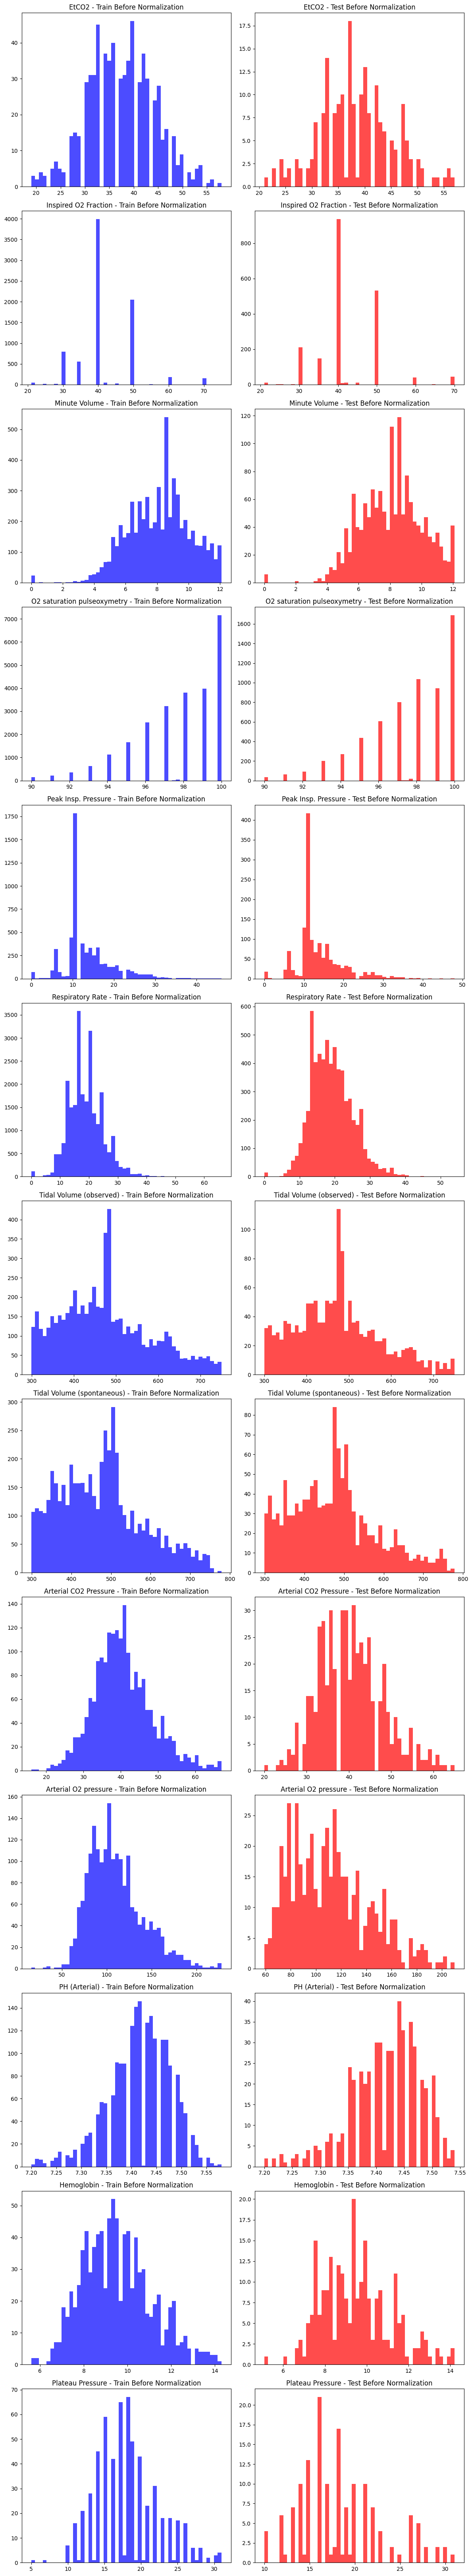

In [ ]:
# Plot histograms for numerical features before normalization
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 5 * len(numerical_features)))

for i, feature in enumerate(numerical_features):
    feature_mask_train = train_df_copy['label'] == feature
    feature_mask_test = test_df_copy['label'] == feature

    # Plot training data before normalization
    axes[i, 0].hist(train_df_copy.loc[feature_mask_train, 'valuenum'], bins=50, color='blue', alpha=0.7)
    axes[i, 0].set_title(f'{feature} - Train Before Normalization')

    # Plot test data before normalization
    axes[i, 1].hist(test_df_copy.loc[feature_mask_test, 'valuenum'], bins=50, color='red', alpha=0.7)
    axes[i, 1].set_title(f'{feature} - Test Before Normalization')

plt.tight_layout()
plt.show()

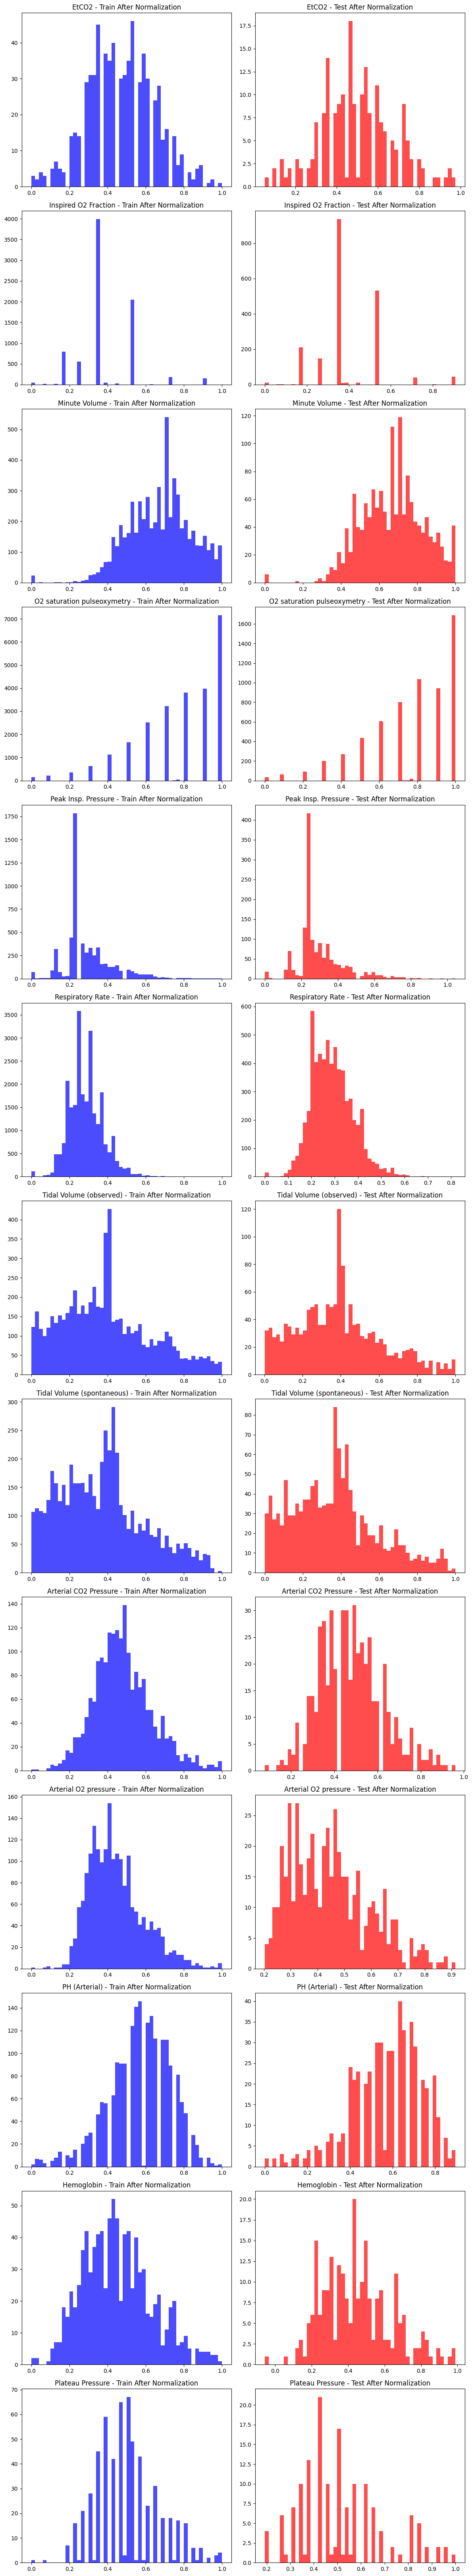

In [ ]:
# Plot histograms for numerical features after normalization
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 5 * len(numerical_features)))

for i, feature in enumerate(numerical_features):
    feature_mask_train = train_df['feature_label'] == feature
    feature_mask_test = test_df['feature_label'] == feature

    # Plot training data after normalization
    axes[i, 0].hist(train_df.loc[feature_mask_train, 'valuenum'], bins=50, color='blue', alpha=0.7)
    axes[i, 0].set_title(f'{feature} - Train After Normalization')

    # Plot test data after normalization
    axes[i, 1].hist(test_df.loc[feature_mask_test, 'valuenum'], bins=50, color='red', alpha=0.7)
    axes[i, 1].set_title(f'{feature} - Test After Normalization')

plt.tight_layout()
plt.show()

**02 - Resampling data to uniform time steps**

Each patient needs sequences of data for each feature, with regular sampling frequency.

We will need to impute and resample the data to achieve this given data collection seems to be sporadic in the original MIMIC data.

Time series models, including LSTM, require input data to have a consistent interval between observation for best performance.

In [ ]:
# Group by subject_id and itemid to count the number of samples for each combination
per_patient_sampling_frequency = train_df.groupby(['subject_id', 'feature_label']).size().reset_index(name='count')

per_patient_sampling_frequency_pivot = per_patient_sampling_frequency.pivot(index='subject_id', columns='feature_label', values='count').fillna(0)

# Calculate the average sampling frequency per feature
average_sampling_frequency = per_patient_sampling_frequency_pivot.mean().sort_values(ascending=False)

# Create columns for the table
average_sampling_frequency_df = pd.DataFrame({'Feature': average_sampling_frequency.index, 'Average Train Set Sampling Frequency': average_sampling_frequency.values})

# Display the table
average_sampling_frequency_df

,Feature,Average Train Set Sampling Frequency
0,Respiratory Rate,6.619149
1,O2 saturation pulseoxymetry,6.615691
2,Inspired O2 Fraction,2.106117
3,Tidal Volume (observed),1.615691
4,Minute Volume,1.602394
5,Peak Insp. Pressure,1.527394
6,Tidal Volume (spontaneous),1.371543
7,Ventilator Mode,1.218883
8,PH (Arterial),0.532447
9,Arterial CO2 Pressure,0.524202


Features are sampled at varying rates from 6/7 times in 6 hours to 0.15 times every 6 hours as per the above.

For our data, we need all features to be sampled uniformly over the same time intervals and need to consider the desired sampling frequency, uniformity and level of interpolation.

Excessive interpolation for features with low sampling rates can introduce noise and misleading trends, but sufficient temporal resolution is required for model training.

For the purposes of this data, a resampling rate of every 30 mins was chosen as a balance of temporal details without excessive interpolation.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93421 entries, 0 to 93420
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   subject_id                   93421 non-null  int64  
 1   itemid                       93421 non-null  int64  
 2   valuenum                     93421 non-null  float64
 3   time_to_extubation_mins      93421 non-null  float64
 4   time_from_window_start_mins  93421 non-null  float64
 5   feature_label                93421 non-null  object 
 6   extubation_failure           93421 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 5.0+ MB


In [ ]:
# Convert the time column to timedelta
train_df['time_from_window_start_mins'] = pd.to_timedelta(train_df['time_from_window_start_mins'], unit='m')
test_df['time_from_window_start_mins'] = pd.to_timedelta(test_df['time_from_window_start_mins'], unit='m')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93421 entries, 0 to 93420
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   subject_id                   93421 non-null  int64          
 1   itemid                       93421 non-null  int64          
 2   valuenum                     93421 non-null  float64        
 3   time_to_extubation_mins      93421 non-null  float64        
 4   time_from_window_start_mins  93421 non-null  timedelta64[ns]
 5   feature_label                93421 non-null  object         
 6   extubation_failure           93421 non-null  int64          
dtypes: float64(2), int64(3), object(1), timedelta64[ns](1)
memory usage: 5.0+ MB


We have a few classic ways in which we can impute the data.

Forward fill - filling from a value
Backward fill - filling backwards from a value

The issue with these is for features in patients that have one or no measurements - forward and backward fill will not be possible.

As such we can use more sophisticated methods that are simple and not too comutationally intensive:
- Linear or Spline Interpolation

Other methods are possible e.g. Kalman Smoothing or KNN Inputation but those are computationally intensive and relativeky complex for the purposes of this study.

Simple forward and backward fill would limit possible temporal patterns.

However, linear or spline interpolation relies on having boundary values to interpolate between.

Given the nature of the variables / features being used - a tailored imputation strategy is necessary.

Linear interpolation is useful for variables with frequent changes or those that dont require a smooth curve.

Spline interpolation is suitable for variables that change smoothly and continuously.

As such, with domain knowledge and conversations with clinicians, the following logic will be used for data resampling and imputation:

**Create start and end values:**
- If a feature for a patient has a value within the first or last 15 mins then that is treated as the start / 0 min value or the end / 360 min value respectively
- If this is not present, the average value for that feature across all patients in the first / last 15 mins will be taken (these mean values need to be saved from the training data and applied to the test data


**Missing value imputation:**

- Missing values left shall be inputed using Linear interpolation and Spline interpolation between all values present for that feature for each patient as follows:

Linear Interpolation:  Respiratory Rate, Minute Volume, Tidal Volume (observed), Tidal Volume (spontaneous)

Reason: These features can exhibit rapid changes and might not benefit significantly from the smoothness provided by spline interpolation.

Spline Interpolation: EtCO2, Inspired O2 Fraction, O2 saturation pulseoxymetry, Arterial CO2 Pressure, Arterial O2 pressure, PH (Arterial), Hemoglobin, Plateau Pressure

Reason: These features are more likely to change smoothly and benefit from the continuous nature of spline interpolation, providing a better fit to the underlying physiological trends.

**Handle Categorical Variables:**

This will need to be done for Ventilation Mode. If no value is present at the start, the most common ventilation mode in the first 15 mins across all patients should be taken as this is likley the start mode. And if no value is present at the end then the most common ventilation mode should be taken across all patients in the last 15 mins before extubation. Any missing values can be mode imputed for the most common value in a 30 min window around that time point.


In [ ]:
# Define the start and end time windows
start_window = pd.Timedelta(minutes=15)
end_window_start = pd.Timedelta(minutes=345)

In [ ]:
# Calculate the mean values for each feature at the start and end windows
start_means = train_df[(train_df['time_from_window_start_mins'] <= start_window) &
                       (train_df['feature_label'] != 'Ventilator Mode')].groupby('feature_label')['valuenum'].mean()

end_means = train_df[(train_df['time_from_window_start_mins'] >= end_window_start) &
                     (train_df['feature_label'] != 'Ventilator Mode')].groupby('feature_label')['valuenum'].mean()

print("Start Means:")
print(start_means)

print("\nEnd Means:")
print(end_means)

# These will need to be applied to the test data

Start Means:
feature_label
Arterial CO2 Pressure          0.494921
Arterial O2 pressure           0.419641
EtCO2                          0.402752
Hemoglobin                     0.458441
Inspired O2 Fraction           0.388926
Minute Volume                  0.682479
O2 saturation pulseoxymetry    0.778495
PH (Arterial)                  0.583185
Peak Insp. Pressure            0.345044
Plateau Pressure               0.522625
Respiratory Rate               0.289925
Tidal Volume (observed)        0.379162
Tidal Volume (spontaneous)     0.347543
Name: valuenum, dtype: float64

End Means:
feature_label
Arterial CO2 Pressure          0.449318
Arterial O2 pressure           0.462550
EtCO2                          0.560558
Hemoglobin                     0.422989
Inspired O2 Fraction           0.458996
Minute Volume                  0.648147
O2 saturation pulseoxymetry    0.740812
PH (Arterial)                  0.582931
Peak Insp. Pressure            0.170533
Plateau Pressure               0.528

Values are small as data has been min-max scaled

In [ ]:
# Calculate the most common value for "Ventilator Mode" in the start and end windows
ventilator_start_mode = train_df[(train_df['time_from_window_start_mins'] <= start_window) &
                                 (train_df['feature_label'] == 'Ventilator Mode')]['valuenum'].mode()[0]

ventilator_end_mode = train_df[(train_df['time_from_window_start_mins'] >= end_window_start) &
                               (train_df['feature_label'] == 'Ventilator Mode')]['valuenum'].mode()[0]


ventilator_start_mode

11.0

In [ ]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

In [ ]:
train_df_copy_2 = train_df.copy()

In [ ]:
def fill_start_end_values(df, start_means, end_means, start_window, end_window_start):
    """
    Fill missing start and end values for features in a DataFrame with specified means or existing values.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing time series data for various features.
    start_means (pd.Series): A Series containing mean values for each feature to be used if no start value is present.
    end_means (pd.Series): A Series containing mean values for each feature to be used if no end value is present.
    start_window (pd.Timedelta): The time window within which to look for a starting value.
    end_window_start (pd.Timedelta): The start time for the window within which to look for an ending value.

    Returns:
    pd.DataFrame: The DataFrame with filled start and end values.
    """
    new_rows = []

    for feature in start_means.index:
        for subject_id in df['subject_id'].unique():
            subject_df = df[df['subject_id'] == subject_id]
            extubation_failure_label = subject_df['extubation_failure'].iloc[0]

            # Handle start values
            start_check = (subject_df['feature_label'] == feature) & (subject_df['time_from_window_start_mins'] == pd.Timedelta(minutes=0))
            if not start_check.any():
                # Check if there's a value in the first 15 mins
                start_window_check = (subject_df['feature_label'] == feature) & (subject_df['time_from_window_start_mins'] <= start_window)
                if start_window_check.any():
                    # Use the earliest value within the start window
                    start_value = subject_df[start_window_check].sort_values('time_from_window_start_mins').iloc[0]['valuenum']
                    new_rows.append({
                        'subject_id': subject_id,
                        'feature_label': feature,
                        'time_from_window_start_mins': pd.Timedelta(minutes=0),
                        'valuenum': start_value,
                        'extubation_failure': extubation_failure_label
                    })
                else:
                    # Use the mean start value if no value is found within the start window
                    new_rows.append({
                        'subject_id': subject_id,
                        'feature_label': feature,
                        'time_from_window_start_mins': pd.Timedelta(minutes=0),
                        'valuenum': start_means[feature],
                        'extubation_failure': extubation_failure_label
                    })

            # Handle end values
            end_check = (subject_df['feature_label'] == feature) & (subject_df['time_from_window_start_mins'] == pd.Timedelta(minutes=360))
            if not end_check.any():
                # Check if there's a value in the last 15 mins
                end_window_check = (subject_df['feature_label'] == feature) & (subject_df['time_from_window_start_mins'] >= end_window_start)
                if end_window_check.any():
                    # Use the latest value within the end window
                    end_value = subject_df[end_window_check].sort_values('time_from_window_start_mins', ascending=False).iloc[0]['valuenum']
                    new_rows.append({
                        'subject_id': subject_id,
                        'feature_label': feature,
                        'time_from_window_start_mins': pd.Timedelta(minutes=360),
                        'valuenum': end_value,
                        'extubation_failure': extubation_failure_label
                    })
                else:
                    # Use the mean end value if no value is found within the end window
                    new_rows.append({
                        'subject_id': subject_id,
                        'feature_label': feature,
                        'time_from_window_start_mins': pd.Timedelta(minutes=360),
                        'valuenum': end_means[feature],
                        'extubation_failure': extubation_failure_label
                    })

    # Add new rows to the dataframe
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        df = pd.concat([df, new_df], ignore_index=True)

    return df


In [ ]:
# Apply start and end values for numerical features

train_df_copy = fill_start_end_values(train_df_copy, start_means, end_means, start_window, end_window_start)

In [ ]:
train_df_copy.head()

,subject_id,itemid,valuenum,time_to_extubation_mins,time_from_window_start_mins,feature_label,extubation_failure
0,10001884,228640.0,0.692308,160.0,0 days 03:20:00,EtCO2,1.0
1,10001884,223835.0,0.351852,160.0,0 days 03:20:00,Inspired O2 Fraction,1.0
2,10001884,224687.0,0.504132,160.0,0 days 03:20:00,Minute Volume,1.0
3,10001884,220277.0,1.000000,337.0,0 days 00:23:00,O2 saturation pulseoxymetry,1.0
4,10001884,220277.0,0.900000,336.0,0 days 00:24:00,O2 saturation pulseoxymetry,1.0


In [ ]:
train_df_copy_2 = fill_start_end_values(train_df_copy_2, start_means, end_means, start_window, end_window_start)

train_df_copy_2.head()

,subject_id,itemid,valuenum,time_to_extubation_mins,time_from_window_start_mins,feature_label,extubation_failure
0,10001884,228640.0,0.692308,160.0,0 days 03:20:00,EtCO2,1
1,10001884,223835.0,0.351852,160.0,0 days 03:20:00,Inspired O2 Fraction,1
2,10001884,224687.0,0.504132,160.0,0 days 03:20:00,Minute Volume,1
3,10001884,220277.0,1.000000,337.0,0 days 00:23:00,O2 saturation pulseoxymetry,1
4,10001884,220277.0,0.900000,336.0,0 days 00:24:00,O2 saturation pulseoxymetry,1


In [ ]:
# drop itemid and time_to_extubation columns
train_df_copy_2 = train_df_copy_2.drop(['itemid', 'time_to_extubation_mins'], axis=1)

# Count the NaN values
nan_counts = train_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
time_from_window_start_mins    0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
def fill_ventilator_mode_start_end(train_df, start_window, end_window_start, ventilator_start_mode, ventilator_end_mode):
    """
    Fill missing start and end values for 'Ventilator Mode' in a DataFrame.

    Parameters:
    train_df (pd.DataFrame): The input DataFrame containing time series data for various features.
    start_window (pd.Timedelta): The time window within which to look for a starting value.
    end_window_start (pd.Timedelta): The start time for the window within which to look for an ending value.
    ventilator_start_mode (int): The default start mode for the ventilator if no value is found.
    ventilator_end_mode (int): The default end mode for the ventilator if no value is found.

    Returns:
    pd.DataFrame: The DataFrame with filled start and end values for 'Ventilator Mode'.
    """
    new_rows = []

    for subject_id in train_df['subject_id'].unique():
        subject_df = train_df[train_df['subject_id'] == subject_id]
        extubation_failure_label = subject_df['extubation_failure'].iloc[0]

        # Fill start value
        ventilator_start_check = (subject_df['feature_label'] == 'Ventilator Mode') & (subject_df['time_from_window_start_mins'] == pd.Timedelta(minutes=0))
        if not ventilator_start_check.any():
            ventilator_start_window_check = (subject_df['feature_label'] == 'Ventilator Mode') & (subject_df['time_from_window_start_mins'] <= start_window)
            if ventilator_start_window_check.any():
                ventilator_start_value = subject_df[ventilator_start_window_check].sort_values('time_from_window_start_mins').iloc[0]['valuenum']
                new_rows.append({
                    'subject_id': subject_id,
                    'feature_label': 'Ventilator Mode',
                    'time_from_window_start_mins': pd.Timedelta(minutes=0),
                    'valuenum': ventilator_start_value,
                    'extubation_failure': extubation_failure_label
                })
            else:
                new_rows.append({
                    'subject_id': subject_id,
                    'feature_label': 'Ventilator Mode',
                    'time_from_window_start_mins': pd.Timedelta(minutes=0),
                    'valuenum': ventilator_start_mode,
                    'extubation_failure': extubation_failure_label
                })

        # Fill end value
        ventilator_end_check = (subject_df['feature_label'] == 'Ventilator Mode') & (subject_df['time_from_window_start_mins'] == pd.Timedelta(minutes=360))
        if not ventilator_end_check.any():
            ventilator_end_window_check = (subject_df['feature_label'] == 'Ventilator Mode') & (subject_df['time_from_window_start_mins'] >= end_window_start)
            if ventilator_end_window_check.any():
                ventilator_end_value = subject_df[ventilator_end_window_check].sort_values('time_from_window_start_mins', ascending=False).iloc[0]['valuenum']
                new_rows.append({
                    'subject_id': subject_id,
                    'feature_label': 'Ventilator Mode',
                    'time_from_window_start_mins': pd.Timedelta(minutes=360),
                    'valuenum': ventilator_end_value,
                    'extubation_failure': extubation_failure_label
                })
            else:
                new_rows.append({
                    'subject_id': subject_id,
                    'feature_label': 'Ventilator Mode',
                    'time_from_window_start_mins': pd.Timedelta(minutes=360),
                    'valuenum': ventilator_end_mode,
                    'extubation_failure': extubation_failure_label
                })

    # Add new rows to the dataframe
    if new_rows:
        new_df = pd.DataFrame(new_rows)
        train_df = pd.concat([train_df, new_df], ignore_index=True)

    return train_df

In [ ]:
train_df_copy.head()

,subject_id,itemid,valuenum,time_to_extubation_mins,time_from_window_start_mins,feature_label,extubation_failure
0,10001884,228640.0,0.692308,160.0,0 days 03:20:00,EtCO2,1.0
1,10001884,223835.0,0.351852,160.0,0 days 03:20:00,Inspired O2 Fraction,1.0
2,10001884,224687.0,0.504132,160.0,0 days 03:20:00,Minute Volume,1.0
3,10001884,220277.0,1.000000,337.0,0 days 00:23:00,O2 saturation pulseoxymetry,1.0
4,10001884,220277.0,0.900000,336.0,0 days 00:24:00,O2 saturation pulseoxymetry,1.0


In [ ]:
train_df_copy_2 = fill_ventilator_mode_start_end(train_df_copy_2, start_window, end_window_start, ventilator_start_mode, ventilator_end_mode)

train_df_copy_2.head()

,subject_id,valuenum,time_from_window_start_mins,feature_label,extubation_failure
0,10001884,0.692308,0 days 03:20:00,EtCO2,1
1,10001884,0.351852,0 days 03:20:00,Inspired O2 Fraction,1
2,10001884,0.504132,0 days 03:20:00,Minute Volume,1
3,10001884,1.000000,0 days 00:23:00,O2 saturation pulseoxymetry,1
4,10001884,0.900000,0 days 00:24:00,O2 saturation pulseoxymetry,1


In [ ]:
# Check for NaN values
nan_counts = train_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
time_from_window_start_mins    0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Check if every feature for every patient has a value at 0 mins and 360 mins
def check_start_end_values(df):
    start_check = df[df['time_from_window_start_mins'] == pd.Timedelta(minutes=0)]
    end_check = df[df['time_from_window_start_mins'] == pd.Timedelta(minutes=360)]

    missing_start = []
    missing_end = []

    for subject_id in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == subject_id]
        for feature in df['feature_label'].unique():
            if not ((subject_df['feature_label'] == feature) & (subject_df['time_from_window_start_mins'] == pd.Timedelta(minutes=0))).any():
                missing_start.append((subject_id, feature))
            if not ((subject_df['feature_label'] == feature) & (subject_df['time_from_window_start_mins'] == pd.Timedelta(minutes=360))).any():
                missing_end.append((subject_id, feature))

    return missing_start, missing_end

In [ ]:
# Run the check
missing_start_values, missing_end_values = check_start_end_values(train_df_copy)

# Display the results
print(f"Missing start values (0 mins) for {len(missing_start_values)} subject-feature pairs:")
print(missing_start_values)
print(f"Missing end values (360 mins) for {len(missing_end_values)} subject-feature pairs:")
print(missing_end_values)

Missing start values (0 mins) for 0 subject-feature pairs:
[]
Missing end values (360 mins) for 0 subject-feature pairs:
[]


In [ ]:
missing_2_start, missing_2_end = check_start_end_values(train_df_copy_2)

print(f"Missing start values (0 mins) for {len(missing_2_start)} subject-feature pairs:")
print(missing_2_start)
print(f"Missing end values (360 mins) for {len(missing_2_end)} subject-feature pairs:")
print(missing_2_end)

Missing start values (0 mins) for 0 subject-feature pairs:
[]
Missing end values (360 mins) for 0 subject-feature pairs:
[]


In [ ]:
# Make a copy of train_df_2
train_df_copy_2_copy = train_df_copy_2.copy()

All patients have a start and end time point from which we can start creating the uniform time series data.

In [ ]:
time_interval = '30T'

In [ ]:
# Resample and interpolate missing values for numerical features
def resample_and_interpolate(df, linear_features, spline_features, interval=time_interval):
    resampled_dfs = []

    for subject_id in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == subject_id]

        for feature in df['feature_label'].unique():
            feature_df = subject_df[subject_df['feature_label'] == feature].set_index('time_from_window_start_mins')

            # Resample to ensure data points at every interval
            feature_df = feature_df.resample(interval).asfreq()

            # Interpolate missing values - spline needs k+1 data points so check if fails and otherwise apply linear
            if feature in spline_features and feature_df['valuenum'].notna().sum() > 2:
                try:
                    feature_df = feature_df.interpolate(method='spline', order=2)
                except Exception as e:
                    print(f"Spline interpolation failed for subject {subject_id}, feature {feature}: {e}")
                    feature_df = feature_df.interpolate(method='linear')
            else:
                feature_df = feature_df.interpolate(method='linear')

            # Forward fill to handle any leading NaNs created by resampling
            feature_df = feature_df.ffill().bfill()

            # Restore subject_id and feature_label columns
            feature_df['subject_id'] = subject_id
            feature_df['feature_label'] = feature

            resampled_dfs.append(feature_df.reset_index())

    # Concatenate all resampled dataframes
    resampled_df = pd.concat(resampled_dfs).reset_index(drop=True)

    return resampled_df

In [ ]:
# Define the numerical features based on domain knowledge
linear_interpolation_features = [
    'Respiratory Rate', 'Minute Volume', 'Tidal Volume (observed)', 'Tidal Volume (spontaneous)'
]

spline_interpolation_features = [
    'EtCO2', 'Inspired O2 Fraction', 'O2 saturation pulseoxymetry',
    'Arterial CO2 Pressure', 'Arterial O2 pressure', 'PH (Arterial)',
    'Hemoglobin', 'Plateau Pressure'
]

In [ ]:
# Apply resampling and interpolation to the training data
train_df_copy = resample_and_interpolate(train_df_copy, linear_interpolation_features, spline_interpolation_features)

train_df_copy.head()

Spline interpolation failed for subject 10004720, feature Inspired O2 Fraction: (m>k) failed for hidden m: fpcurf0:m=2
Spline interpolation failed for subject 10024982, feature Inspired O2 Fraction: (m>k) failed for hidden m: fpcurf0:m=2
Spline interpolation failed for subject 10024982, feature O2 saturation pulseoxymetry: (m>k) failed for hidden m: fpcurf0:m=2
Spline interpolation failed for subject 10029291, feature Inspired O2 Fraction: (m>k) failed for hidden m: fpcurf0:m=1
Spline interpolation failed for subject 10040025, feature Plateau Pressure: (m>k) failed for hidden m: fpcurf0:m=1
Spline interpolation failed for subject 10102878, feature Arterial CO2 Pressure: (m>k) failed for hidden m: fpcurf0:m=1
Spline interpolation failed for subject 10102878, feature Arterial O2 pressure: (m>k) failed for hidden m: fpcurf0:m=1
Spline interpolation failed for subject 10102878, feature PH (Arterial): (m>k) failed for hidden m: fpcurf0:m=1
Spline interpolation failed for subject 10160622, f

KeyboardInterrupt: 

Spline interpolation typically requires k+1 data points to interpolate where k is the order of the spline.

A number of features have fewer than 3 data points per patient and so the spline transformation is failing.

As such, we will use linear interpolation throughout.

In [ ]:
# Function to resample and interpolate missing values using linear interpolation
def resample_and_interpolate_2(df, numerical_features, interval=time_interval):
    resampled_dfs = []

    for subject_id in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == subject_id]

        for feature in df['feature_label'].unique():
            feature_df = subject_df[subject_df['feature_label'] == feature].set_index('time_from_window_start_mins')

            # Resample to ensure data points at every interval
            feature_df = feature_df.resample(interval).asfreq()

            # Interpolate missing values if the feature is numerical
            if feature in numerical_features:
                feature_df = feature_df.interpolate(method='linear')
                # Forward fill to handle any leading NaNs created by resampling
                feature_df = feature_df.ffill().bfill()

            # Restore subject_id and feature_label columns
            feature_df['subject_id'] = subject_id
            feature_df['feature_label'] = feature

            resampled_dfs.append(feature_df.reset_index())

    # Concatenate all resampled dataframes
    resampled_df = pd.concat(resampled_dfs).reset_index(drop=True)

    return resampled_df

In [ ]:
# Define the numerical features
numerical_features = [
    'Respiratory Rate', 'Minute Volume', 'Tidal Volume (observed)', 'Tidal Volume (spontaneous)',
    'EtCO2', 'Inspired O2 Fraction', 'O2 saturation pulseoxymetry',
    'Arterial CO2 Pressure', 'Arterial O2 pressure', 'PH (Arterial)',
    'Hemoglobin', 'Plateau Pressure'
]

In [ ]:
# Apply updated interpolation strategy to data
train_df_copy = resample_and_interpolate_2(train_df_copy, numerical_features)

train_df_copy.head()

ValueError: cannot reindex on an axis with duplicate labels

The error indicates that there are duplicate labels in the DataFrame's index after resampling. This can happen if the time_from_window_start_mins column has duplicate values for the same subject_id and feature_label.

In [ ]:
def resample_and_interpolate_3(df, numerical_features, interval='30T'):
    resampled_dfs = []

    for subject_id in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == subject_id]

        for feature in df['feature_label'].unique():
            feature_df = subject_df[subject_df['feature_label'] == feature].set_index('time_from_window_start_mins')

            # Remove duplicates by taking the first value if duplicates exist
            feature_df = feature_df[~feature_df.index.duplicated(keep='first')]

            # Preserve additional columns before resampling
            additional_columns = feature_df[['extubation_failure']]

            # additional_columns = feature_df[['itemid', 'time_to_extubation_mins', 'extubation_failure']]


            # Resample to ensure data points at every interval
            feature_df = feature_df.resample(interval).asfreq()

            # Interpolate missing values if the feature is numerical
            if feature in numerical_features:
                feature_df['valuenum'] = feature_df['valuenum'].interpolate(method='linear')
                # Forward fill to handle any leading NaNs created by resampling
                feature_df['valuenum'] = feature_df['valuenum'].ffill().bfill()

            # Align additional columns with the resampled index and forward/backward fill
            for col in additional_columns.columns:
                feature_df[col] = feature_df[col].ffill().bfill()

            # Restore subject_id and feature_label columns
            feature_df['subject_id'] = subject_id
            feature_df['feature_label'] = feature

            resampled_dfs.append(feature_df.reset_index())

    # Concatenate all resampled dataframes
    resampled_df = pd.concat(resampled_dfs).reset_index(drop=True)

    return resampled_df


In [ ]:
train_df_copy = resample_and_interpolate_3(train_df_copy, numerical_features)

train_df_copy.head()

,time_from_window_start_mins,subject_id,itemid,valuenum,time_to_extubation_mins,feature_label,extubation_failure
0,0 days 00:00:00,10001884,NaN,0.402752,NaN,EtCO2,NaN
1,0 days 00:30:00,10001884,NaN,0.415902,NaN,EtCO2,NaN
2,0 days 01:00:00,10001884,NaN,0.429053,NaN,EtCO2,NaN
3,0 days 01:30:00,10001884,NaN,0.442203,NaN,EtCO2,NaN
4,0 days 02:00:00,10001884,NaN,0.455354,NaN,EtCO2,NaN


In [ ]:
# Count the number of NaNs
nan_counts = train_df_copy.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins         0
subject_id                          0
itemid                         607360
valuenum                        40665
time_to_extubation_mins        607360
feature_label                       0
extubation_failure             607360
dtype: int64


In [ ]:
# Apply to train_df_copy_2
train_df_copy_2 = resample_and_interpolate_3(train_df_copy_2, numerical_features)

train_df_copy_2.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.402752,EtCO2,1.0
1,0 days 00:30:00,10001884,0.415902,EtCO2,1.0
2,0 days 01:00:00,10001884,0.429053,EtCO2,1.0
3,0 days 01:30:00,10001884,0.442203,EtCO2,1.0
4,0 days 02:00:00,10001884,0.455354,EtCO2,1.0


In [ ]:
# Count NaNs
nan_counts = train_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins        0
subject_id                         0
valuenum                       40665
feature_label                      0
extubation_failure                 0
dtype: int64


In [ ]:
# Count at what time points these valuenum NaNs are occuring
train_df_copy_2[train_df_copy_2['valuenum'].isna()]['time_from_window_start_mins'].value_counts()


time_from_window_start_mins
0 days 04:30:00    3715
0 days 02:30:00    3713
0 days 01:30:00    3710
0 days 05:30:00    3706
0 days 00:30:00    3700
0 days 01:00:00    3696
0 days 03:30:00    3694
0 days 02:00:00    3686
0 days 05:00:00    3684
0 days 04:00:00    3682
0 days 03:00:00    3679
Name: count, dtype: int64

There still seem to be several NaN values which need to be dealt with.

The function needs to be able to catch any NaNs that are left over after linear interpolation has been attempted. It is likely that there are not enough time points to fully interpolate.

In [ ]:
train_df_copy_2 = train_df_copy_2_copy

In [ ]:
def resample_and_interpolate_4(df, numerical_features, interval='30T'):
    """
    Resample and interpolate missing values for numerical features in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing time series data for various features.
    numerical_features (list): A list of numerical features to be interpolated.
    interval (str): The resampling interval. Default is '30T' (30 minutes).

    Returns:
    pd.DataFrame: The DataFrame with resampled and interpolated values.
    """
    resampled_dfs = []

    for subject_id in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == subject_id]

        for feature in df['feature_label'].unique():
            feature_df = subject_df[subject_df['feature_label'] == feature].set_index('time_from_window_start_mins')

            # Remove duplicates by taking the first value if duplicates exist
            feature_df = feature_df[~feature_df.index.duplicated(keep='first')]

            # Preserve additional columns before resampling
            additional_columns = feature_df[['extubation_failure']]

            # Resample to ensure data points at every interval
            feature_df = feature_df.resample(interval).asfreq()

            # Interpolate missing values if the feature is numerical
            if feature in numerical_features:
                # Forward fill and backward fill to handle leading/trailing NaNs
                # feature_df['valuenum'] = feature_df['valuenum'].ffill().bfill()

                # Interpolate values
                feature_df['valuenum'] = feature_df['valuenum'].interpolate(method='linear')

            # Align extubation_failure columns with the resampled index and forward/backward fill for each patient
            for col in additional_columns.columns:
                feature_df[col] = feature_df[col].ffill().bfill()

            # Restore subject_id and feature_label columns
            feature_df['subject_id'] = subject_id
            feature_df['feature_label'] = feature

            resampled_dfs.append(feature_df.reset_index())

    # Concatenate all resampled dataframes
    resampled_df = pd.concat(resampled_dfs).reset_index(drop=True)

    return resampled_df

In [ ]:
# Apply amended function
train_df_copy_2 = resample_and_interpolate_4(train_df_copy_2, numerical_features)

# Count NaN values
nan_counts = train_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins        0
subject_id                         0
valuenum                       40665
feature_label                      0
extubation_failure                 0
dtype: int64


In [ ]:
nan_rows = train_df_copy_2[train_df_copy_2['valuenum'].isna()]

# Group by subject and feature to see where NaNs are most common
nan_summary = nan_rows.groupby(['subject_id', 'feature_label']).size().reset_index(name='count')

print("Summary of NaNs by subject and feature:")
print(nan_summary)


Summary of NaNs by subject and feature:
      subject_id    feature_label  count
0       10001884  Ventilator Mode     11
1       10002428  Ventilator Mode     11
2       10004235  Ventilator Mode     11
3       10004720  Ventilator Mode     11
4       10004733  Ventilator Mode     11
...          ...              ...    ...
3755    17907596  Ventilator Mode     11
3756    17907953  Ventilator Mode     11
3757    17909008  Ventilator Mode     11
3758    17910586  Ventilator Mode     11
3759    17912822  Ventilator Mode      9

[3760 rows x 3 columns]


In [ ]:
# Show the first few rows with NaNs to analyze
print("First few rows with NaNs:")
print(nan_rows.head())

First few rows with NaNs:
    time_from_window_start_mins  subject_id  valuenum    feature_label  \
144             0 days 00:30:00    10001884       NaN  Ventilator Mode   
145             0 days 01:00:00    10001884       NaN  Ventilator Mode   
146             0 days 01:30:00    10001884       NaN  Ventilator Mode   
147             0 days 02:00:00    10001884       NaN  Ventilator Mode   
148             0 days 02:30:00    10001884       NaN  Ventilator Mode   

     extubation_failure  
144                 1.0  
145                 1.0  
146                 1.0  
147                 1.0  
148                 1.0  


In [ ]:
# Count the NaNs per label
nan_counts = nan_rows['feature_label'].value_counts()

# Display the results
print(nan_counts)

feature_label
Ventilator Mode    40665
Name: count, dtype: int64


Now we know the NaNs are only Ventilator Mode as expected, we can fully interpolate the data.

In [ ]:
def mode_impute_ventilator_mode(df, interval='30T'):
    """
    Mode impute missing values for 'Ventilator Mode' based on the most common value in a 30-minute window.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing time series data.
    interval (str): The resampling interval. Default is '30T' (30 minutes).

    Returns:
    pd.DataFrame: The DataFrame with mode-imputed values for 'Ventilator Mode'.
    """
    # Ensure 'Ventilator Mode' is treated as a categorical feature
    df['valuenum'] = df['valuenum'].astype('category')

    # Create a mask for 'Ventilator Mode'
    ventilator_mode_mask = (df['feature_label'] == 'Ventilator Mode')

    # Get the times that need imputation
    times_to_impute = df[ventilator_mode_mask & df['valuenum'].isna()]['time_from_window_start_mins']

    for time in times_to_impute:
        # Define the window
        window_start = time - pd.Timedelta(minutes=15)
        window_end = time + pd.Timedelta(minutes=15)

        # Filter the dataframe to find the mode within the window
        window_df = df[(df['time_from_window_start_mins'] >= window_start) &
                       (df['time_from_window_start_mins'] <= window_end) &
                       ventilator_mode_mask]

        if not window_df['valuenum'].mode().empty:
            mode_value = window_df['valuenum'].mode().iloc[0]
        else:
            # If no mode is found within the window, fall back to a default value
            mode_value = df[ventilator_mode_mask]['valuenum'].mode().iloc[0]

        # Impute the missing value with the mode
        df.loc[(df['time_from_window_start_mins'] == time) & ventilator_mode_mask, 'valuenum'] = mode_value

    return df

In [ ]:
# Fill in ventilator mode values using mode inputation
train_df_copy_2 = mode_impute_ventilator_mode(train_df_copy_2)

# Count NaN values
nan_counts = train_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Check completeness that all patients have valid data points for 30 min intervals
def check_complete_intervals(df, interval='30T', max_time=pd.Timedelta(minutes=360)):
    """
    Check if every patient and every feature has a value for every interval up to max_time.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing time series data.
    interval (str): The interval to check. Default is '30T' (30 minutes).
    max_time (pd.Timedelta): The maximum time to check for intervals. Default is 360 minutes.

    Returns:
    pd.DataFrame: DataFrame indicating any missing intervals.
    """
    # Create a time index for the intervals
    time_index = pd.timedelta_range(start='0 minutes', end=max_time, freq=interval)

    missing_intervals = []

    for subject_id in df['subject_id'].unique():
        subject_df = df[df['subject_id'] == subject_id]

        for feature in df['feature_label'].unique():
            feature_df = subject_df[subject_df['feature_label'] == feature]
            feature_times = feature_df['time_from_window_start_mins']

            for time in time_index:
                if time not in feature_times.values:
                    missing_intervals.append({
                        'subject_id': subject_id,
                        'feature_label': feature,
                        'missing_interval': time
                    })

    if missing_intervals:
        missing_df = pd.DataFrame(missing_intervals)
    else:
        missing_df = pd.DataFrame(columns=['subject_id', 'feature_label', 'missing_interval'])

    return missing_df

In [ ]:
missing_intervals_df = check_complete_intervals(train_df_copy_2)

print("Missing Intervals:")
print(missing_intervals_df)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


I now have my training data set to consistent length and consisten frequency of 30 mins.

Now we need to apply this to the test data.

In [ ]:
test_df_copy_2 = test_df.copy()
test_df_copy_2.head()

,subject_id,itemid,valuenum,time_to_extubation_mins,time_from_window_start_mins,feature_label,extubation_failure
0,10011427,220235,0.431373,77.0,0 days 04:43:00,Arterial CO2 Pressure,0
1,10011427,220224,0.471698,77.0,0 days 04:43:00,Arterial O2 pressure,0
2,10011427,223835,0.166667,295.0,0 days 01:05:00,Inspired O2 Fraction,0
3,10011427,224687,0.504132,295.0,0 days 01:05:00,Minute Volume,0
4,10011427,220277,1.000000,355.0,0 days 00:05:00,O2 saturation pulseoxymetry,0


In [ ]:
# Drop itemid and time_to_extubation
test_df_copy_2 = test_df_copy_2.drop(['itemid', 'time_to_extubation_mins'], axis=1)
test_df_copy_2.head()

,subject_id,valuenum,time_from_window_start_mins,feature_label,extubation_failure
0,10011427,0.431373,0 days 04:43:00,Arterial CO2 Pressure,0
1,10011427,0.471698,0 days 04:43:00,Arterial O2 pressure,0
2,10011427,0.166667,0 days 01:05:00,Inspired O2 Fraction,0
3,10011427,0.504132,0 days 01:05:00,Minute Volume,0
4,10011427,1.000000,0 days 00:05:00,O2 saturation pulseoxymetry,0


In [ ]:
# List of features from the training data
train_features = train_df_copy_2['feature_label'].unique()

# Ensure the test data has the same features as the training data
test_features = test_df_copy_2['feature_label'].unique()
missing_features = set(train_features) - set(test_features)
missing_features

set()

In [ ]:
# Use start and end means derived from train data to fill the start and end valeus for the test data
test_df_copy_2 = fill_start_end_values(test_df_copy_2, start_means, end_means, start_window, end_window_start)

# Count NaNs
nan_counts = test_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
time_from_window_start_mins    0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Fill starty and end values for ventilator mode using the start and end values from training data
test_df_copy_2 = fill_ventilator_mode_start_end(test_df_copy_2, start_window, end_window_start, ventilator_start_mode, ventilator_end_mode)

# Count NaNs
nan_counts = test_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
time_from_window_start_mins    0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Check start and end values present
missing_start_values_test, missing_end_values_test = check_start_end_values(test_df_copy_2)

# Display the results
print(f"Missing start values (0 mins) for {len(missing_start_values_test)} subject-feature pairs:")
print(missing_start_values_test)
print(f"Missing end values (360 mins) for {len(missing_end_values_test)} subject-feature pairs:")
print(missing_end_values_test)

Missing start values (0 mins) for 0 subject-feature pairs:
[]
Missing end values (360 mins) for 0 subject-feature pairs:
[]


In [ ]:
# Resample and interpolate the test data
test_df_copy_2 = resample_and_interpolate_4(test_df_copy_2, numerical_features)

# Count NaNs
nan_counts = test_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins        0
subject_id                         0
valuenum                       10216
feature_label                      0
extubation_failure                 0
dtype: int64


In [ ]:
# Count the NaNs per label
nan_rows = test_df_copy_2[test_df_copy_2['valuenum'].isna()]

nan_counts = nan_rows['feature_label'].value_counts()

# Display the results
print(nan_counts)

feature_label
Ventilator Mode    10216
Name: count, dtype: int64


In [ ]:
# Fill in ventilator mode values - mode values are derived from the training data
def calculate_window_modes(train_df, feature_label='Ventilator Mode', interval='30T', max_time='360T'):
    """
    Calculate the mode for each time window in the training data.

    Parameters:
    train_df (pd.DataFrame): The training DataFrame containing time series data.
    feature_label (str): The feature label to calculate modes for. Default is 'Ventilator Mode'.
    interval (str): The resampling interval. Default is '30T' (30 minutes).
    max_time (str): The maximum time to check for intervals. Default is '360T' (360 minutes).

    Returns:
    dict: A dictionary with time windows as keys and mode values as values.
    """
    interval = pd.Timedelta(interval)
    max_time = pd.Timedelta(max_time)

    # Initialize a dictionary to store modes for each 30-minute window
    window_mode_dict = {}

    # Calculate modes for each 30-minute window in the training data
    for start_time in pd.timedelta_range(start='0 minutes', end=max_time, freq=interval):
        end_time = start_time + interval
        window_df = train_df[
            (train_df['feature_label'] == feature_label) &
            (train_df['time_from_window_start_mins'] >= start_time) &
            (train_df['time_from_window_start_mins'] < end_time)
        ]
        if not window_df['valuenum'].mode().empty:
            mode_value = window_df['valuenum'].mode().iloc[0]
            window_mode_dict[start_time] = mode_value

    return window_mode_dict






In [ ]:
def test_data_mode_impute_ventilator_mode(test_df, mode_dict, interval='30T'):
    """
    Mode impute missing values for 'Ventilator Mode' based on the most common value in a 30-minute window
    using modes derived from the training data.

    Parameters:
    test_df (pd.DataFrame): The test DataFrame containing time series data.
    mode_dict (dict): Dictionary containing mode values for 'Ventilator Mode' for each 30-minute window.
    interval (str): The resampling interval. Default is '30T' (30 minutes).

    Returns:
    pd.DataFrame: The DataFrame with mode-imputed values for 'Ventilator Mode'.
    """
    interval = pd.Timedelta(interval)

    # Ensure 'Ventilator Mode' is treated as a categorical feature
    test_df['valuenum'] = test_df['valuenum'].astype('category')

    # Create a mask for 'Ventilator Mode'
    ventilator_mode_mask = (test_df['feature_label'] == 'Ventilator Mode')

    # Get the times that need imputation
    times_to_impute = test_df[ventilator_mode_mask & test_df['valuenum'].isna()]['time_from_window_start_mins']

    for time in times_to_impute:
        # Find the nearest start time for the 30-minute window
        nearest_start_time = (time // interval) * interval

        # Use the mode from the training data for the corresponding 30-minute window
        if nearest_start_time in mode_dict:
            mode_value = mode_dict[nearest_start_time]
        else:
            # If no mode is found for the specific window, use the overall mode from training data
            mode_value = test_df[ventilator_mode_mask]['valuenum'].mode().iloc[0]

        # Impute the missing value with the mode
        test_df.loc[(test_df['time_from_window_start_mins'] == time) & ventilator_mode_mask, 'valuenum'] = mode_value

    return test_df

In [ ]:
# Calculate the modes for each 30-minute window in the training data

train_ventilator_mode_dict = calculate_window_modes(train_df_copy_2, feature_label='Ventilator Mode', interval='30T', max_time='360T')

In [ ]:
# Apply model imputation to test data
test_df_copy_2 = test_data_mode_impute_ventilator_mode(test_df_copy_2, train_ventilator_mode_dict)

# Count NaNs
nan_counts = test_df_copy_2.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
train_df_copy_2.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.402752,EtCO2,1.0
1,0 days 00:30:00,10001884,0.402752,EtCO2,1.0
2,0 days 01:00:00,10001884,0.402752,EtCO2,1.0
3,0 days 01:30:00,10001884,0.402752,EtCO2,1.0
4,0 days 02:00:00,10001884,0.402752,EtCO2,1.0


In [ ]:
test_df_copy_2.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10011427,0.494921,Arterial CO2 Pressure,0.0
1,0 days 00:30:00,10011427,0.494921,Arterial CO2 Pressure,0.0
2,0 days 01:00:00,10011427,0.494921,Arterial CO2 Pressure,0.0
3,0 days 01:30:00,10011427,0.494921,Arterial CO2 Pressure,0.0
4,0 days 02:00:00,10011427,0.494921,Arterial CO2 Pressure,0.0


In [ ]:
missing_test_intervals = check_complete_intervals(test_df_copy_2)

print("Missing Intervals:")
print(missing_test_intervals)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


In [ ]:
# Make extubation_failure integers in train and test data
train_df_copy_2['extubation_failure'] = train_df_copy_2['extubation_failure'].astype('int64')
test_df_copy_2['extubation_failure'] = test_df_copy_2['extubation_failure'].astype('int64')

train_df_copy_2.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.402752,EtCO2,1
1,0 days 00:30:00,10001884,0.402752,EtCO2,1
2,0 days 01:00:00,10001884,0.402752,EtCO2,1
3,0 days 01:30:00,10001884,0.402752,EtCO2,1
4,0 days 02:00:00,10001884,0.402752,EtCO2,1


In [ ]:
train_df_final = train_df_copy_2.copy()
test_df_final = test_df_copy_2.copy()

In [ ]:
# Save preprocessed train and test data for feature set 1 dynamic features]
train_df_final.to_csv('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/train_test_sets/train_df_preprocessed_v01.csv', index=False)
test_df_final.to_csv('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/07_data_preprocessing/01_feature_set_1/train_test_sets/test_df_preprocessed_v01.csv', index=False)

We have now resampled and imputed all data in the train and test sets.



# **Convert Time Series Data into Sequences for LSTM**

LSTMs require input data in the form of sequences. Each sequence can represent a window of time steps for each fetaure of a patient.

As such we need to create sequences and ensure that each sequence has the same length and format as required by the LSTM model.

First we need to separate the input features and the target label (extubation_failure) for training and testing.

**Step 1 - Convert the time series data into sequences**

Each sequence represents a window of time steps for the LSTM.

In [ ]:
# Verify unique feature labels in the initial dataset
initial_features = train_df_final['feature_label'].unique()
print("Initial features:", initial_features)
print("Number of initial features:", len(initial_features))

Initial features: ['EtCO2' 'Inspired O2 Fraction' 'Minute Volume'
 'O2 saturation pulseoxymetry' 'Peak Insp. Pressure' 'Respiratory Rate'
 'Tidal Volume (observed)' 'Tidal Volume (spontaneous)'
 'Arterial CO2 Pressure' 'Arterial O2 pressure' 'PH (Arterial)'
 'Ventilator Mode' 'Hemoglobin' 'Plateau Pressure']
Number of initial features: 14


In [ ]:
def create_sequences(data, sequence_length):
    """
    Convert time series data into sequences for LSTM input, including subject IDs.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing time series data.
    sequence_length (int): The length of each sequence.

    Returns:
    np.array: Numpy array of sequences.
    np.array: Numpy array of labels.
    list: List of subject IDs corresponding to each sequence.
    """
    sequences = []
    labels = []
    subject_ids = []

    # Group data by patient
    grouped = data.groupby('subject_id')

    for subject_id, group in grouped:
        # Ensure data is sorted by time
        group = group.sort_values(by='time_from_window_start_mins')

        # Pivot the data to ensure all features are included
        pivoted_data = group.pivot(index='time_from_window_start_mins', columns='feature_label', values='valuenum')

        # Create sequences
        for i in range(len(pivoted_data) - sequence_length + 1):
            sequence = pivoted_data.iloc[i:i + sequence_length]
            sequences.append(sequence.values)
            labels.append(group['extubation_failure'].iloc[i + sequence_length - 1])
            subject_ids.append(subject_id)

    return np.array(sequences), np.array(labels), subject_ids

In [ ]:
# Define sequence length (number of time steps)
sequence_length = 13  # 13 time steps for 6.5 hours of data at 30-minute intervals


In [ ]:
train_sequences, train_labels, train_subject_ids = create_sequences(train_df_final, sequence_length)

print("Shape of training sequences:", train_sequences.shape)
print("Shape of training labels:", train_labels.shape)

Shape of training sequences: (3760, 13, 14)
Shape of training labels: (3760,)


In [ ]:
# Count the number of unique patients in the training sequences
num_train_patients = len(set(train_subject_ids))
print("Number of unique patients in training sequences:", num_train_patients)

Number of unique patients in training sequences: 3760


In [ ]:
# Count the number of patients in the original train_df
num_train_patients = len(set(train_df_final['subject_id']))
print("Number of unique patients in the original train_df:", num_train_patients)

Number of unique patients in the original train_df: 3760


In [ ]:
test_sequences, test_labels, test_subject_ids = create_sequences(test_df_final, sequence_length)

print("Shape of test sequences:", test_sequences.shape)
print("Shape of test labels:", test_labels.shape)

Shape of test sequences: (941, 13, 14)
Shape of test labels: (941,)


In [ ]:
num_test_patients = len(set(test_subject_ids))
print("Number of unique patients in test sequences:", num_test_patients)

num_org_test_patients = len(set(test_df_final['subject_id']))
print("Number of unique patients in the original test_df:", num_org_test_patients)

Number of unique patients in test sequences: 941
Number of unique patients in the original test_df: 941


We have now arranged our train and test sets into sequences, ready for LSTM model input.

In [ ]:
# Save train and test sequences
output_dir = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/'

In [ ]:
# Save the training data
np.save(output_dir + 'train_sequences.npy', train_sequences)
np.save(output_dir + 'train_labels.npy', train_labels)

# Save the test data
np.save(output_dir + 'test_sequences.npy', test_sequences)
np.save(output_dir + 'test_labels.npy', test_labels)

# **AMENDMENT**

Need to create columns for SpO2:FiO2 ratio and P/F ratio. Realised this has not been done.

The ratios need to be calculated prior to data normalisation. However, data will need to be at consistent sampling frequencies to get ratio values at each time point.

As such, we need to resample the data first, calculate the ratio features and then normalise the data.

**Step 1 - Data resampling to consistent sampling frequencies**

Prior functions will be used to resample the data.

In [ ]:
# Take a copy of the train and test data
train_df_copy_3 = train_df.copy()
test_df_copy_3 = test_df.copy()

train_df_copy_3.head()

,subject_id,itemid,valuenum,time_to_extubation_mins,time_from_window_start,label,extubation_failure
5,10001884,228640,46.0,160.0,200.0,EtCO2,1
0,10001884,223835,40.0,160.0,200.0,Inspired O2 Fraction,1
3,10001884,224687,6.1,160.0,200.0,Minute Volume,1
7,10001884,220277,100.0,337.0,23.0,O2 saturation pulseoxymetry,1
9,10001884,220277,99.0,336.0,24.0,O2 saturation pulseoxymetry,1


In [ ]:
# drop itemid and time_to_extubation columns
train_df_copy_3 = train_df_copy_3.drop(['itemid', 'time_to_extubation_mins'], axis=1)
test_df_copy_3 = test_df_copy_3.drop(['itemid', 'time_to_extubation_mins'], axis=1)

train_df_copy_3.head()

KeyError: "['itemid', 'time_to_extubation_mins'] not found in axis"

In [ ]:
test_df_copy_3 = test_df_copy_3.drop(['itemid', 'time_to_extubation_mins'], axis=1)


In [ ]:
test_df_copy_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23180 entries, 239 to 116636
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              23180 non-null  int64  
 1   valuenum                23180 non-null  float64
 2   time_from_window_start  23180 non-null  float64
 3   label                   23180 non-null  object 
 4   extubation_failure      23180 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
# Convert the time column to timedelta
train_df_copy_3['time_from_window_start_mins'] = pd.to_timedelta(train_df_copy_3['time_from_window_start'], unit='m')
test_df_copy_3['time_from_window_start_mins'] = pd.to_timedelta(test_df_copy_3['time_from_window_start'], unit='m')

train_df_copy_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93421 entries, 5 to 116540
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   subject_id                   93421 non-null  int64          
 1   valuenum                     93421 non-null  float64        
 2   time_from_window_start       93421 non-null  float64        
 3   label                        93421 non-null  object         
 4   extubation_failure           93421 non-null  int64          
 5   time_from_window_start_mins  93421 non-null  timedelta64[ns]
dtypes: float64(2), int64(2), object(1), timedelta64[ns](1)
memory usage: 5.0+ MB


In [ ]:
# Drop time_from_window_start
train_df_copy_3 = train_df_copy_3.drop(['time_from_window_start'], axis=1)
test_df_copy_3 = test_df_copy_3.drop(['time_from_window_start'], axis=1)

KeyError: "['time_from_window_start'] not found in axis"

In [ ]:
train_df_copy_3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93421 entries, 5 to 116540
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   subject_id                   93421 non-null  int64          
 1   valuenum                     93421 non-null  float64        
 2   label                        93421 non-null  object         
 3   extubation_failure           93421 non-null  int64          
 4   time_from_window_start_mins  93421 non-null  timedelta64[ns]
dtypes: float64(1), int64(2), object(1), timedelta64[ns](1)
memory usage: 4.3+ MB


In [ ]:
# Rename label to feature_label
train_df_copy_3 = train_df_copy_3.rename(columns={'label': 'feature_label'})
test_df_copy_3 = test_df_copy_3.rename(columns={'label': 'feature_label'})

In [ ]:
# Define the start and end time windows
start_window = pd.Timedelta(minutes=15)
end_window_start = pd.Timedelta(minutes=345)

In [ ]:
# Calculate the mean values for each numerical feature at the start and end windows on the training data
start_means_3 = train_df_copy_3[(train_df_copy_3['time_from_window_start_mins'] <= start_window) &
                       (train_df_copy_3['feature_label'] != 'Ventilator Mode')].groupby('feature_label')['valuenum'].mean()

end_means_3 = train_df_copy_3[(train_df_copy_3['time_from_window_start_mins'] >= end_window_start) &
                     (train_df_copy_3['feature_label'] != 'Ventilator Mode')].groupby('feature_label')['valuenum'].mean()

print("Start Means:")
print(start_means_3)

print("\nEnd Means:")
print(end_means_3)

# These will need to be applied to the test data

Start Means:
feature_label
Arterial CO2 Pressure           41.240964
Arterial O2 pressure           104.963855
EtCO2                           34.707317
Hemoglobin                       9.588439
Inspired O2 Fraction            42.002026
Minute Volume                    8.258001
O2 saturation pulseoxymetry     97.784951
PH (Arterial)                    7.421610
Peak Insp. Pressure             15.872036
Plateau Pressure                18.588251
Respiratory Rate                19.135051
Tidal Volume (observed)        470.002136
Tidal Volume (spontaneous)     465.715363
Name: valuenum, dtype: float64

End Means:
feature_label
Arterial CO2 Pressure           38.915214
Arterial O2 pressure           114.060606
EtCO2                           40.861751
Hemoglobin                       9.280000
Inspired O2 Fraction            45.785759
Minute Volume                    7.842582
O2 saturation pulseoxymetry     97.408124
PH (Arterial)                    7.421514
Peak Insp. Pressure              7

In [ ]:
# Calculate the most common value for "Ventilator Mode" in the start and end windows on the training data only
ventilator_start_mode_3 = train_df_copy_3[(train_df_copy_3['time_from_window_start_mins'] <= start_window) &
                                 (train_df_copy_3['feature_label'] == 'Ventilator Mode')]['valuenum'].mode()[0]

ventilator_end_mode_3 = train_df_copy_3[(train_df_copy_3['time_from_window_start_mins'] >= end_window_start) &
                               (train_df_copy_3['feature_label'] == 'Ventilator Mode')]['valuenum'].mode()[0]


ventilator_start_mode_3

11.0

In [ ]:
# Make a copy
train_df_copy_3_copy = train_df_copy_3.copy()
test_df_copy_3_copy = test_df_copy_3.copy()

In [ ]:
# Fill in the start and end values for the numerical data
train_df_copy_3 = fill_start_end_values(train_df_copy_3, start_means_3, end_means_3, start_window, end_window_start)

# Count NaNs
nan_counts = train_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
time_from_window_start_mins    0
dtype: int64


In [ ]:
# Fill ventilator mode start and end values
train_df_copy_3 = fill_ventilator_mode_start_end(train_df_copy_3, start_window, end_window_start, ventilator_start_mode_3, ventilator_end_mode_3)

# Count NaNs
nan_counts = train_df = train_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
time_from_window_start_mins    0
dtype: int64


In [ ]:
# Check all start and end values are present
missing_start_values, missing_end_values = check_start_end_values(train_df_copy_3)

# Display the results
print(f"Missing start values (0 mins) for {len(missing_start_values)} subject-feature pairs:")
print(missing_start_values)
print(f"Missing end values (360 mins) for {len(missing_end_values)} subject-feature pairs:")
print(missing_end_values)

Missing start values (0 mins) for 0 subject-feature pairs:
[]
Missing end values (360 mins) for 0 subject-feature pairs:
[]


In [ ]:
time_interval = '30T'

In [ ]:
# Identify the numerical features
numerical_features = train_df_copy_3['feature_label'].unique()
numerical_features = [feature for feature in numerical_features if feature != 'Ventilator Mode']
numerical_features

['EtCO2',
 'Inspired O2 Fraction',
 'Minute Volume',
 'O2 saturation pulseoxymetry',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Arterial CO2 Pressure',
 'Arterial O2 pressure',
 'PH (Arterial)',
 'Hemoglobin',
 'Plateau Pressure']

In [ ]:
# Resample and interpolate the data to 30 min intervals
train_df_copy_3 = resample_and_interpolate_4(train_df_copy_3, numerical_features)

# Count NaNs
nan_counts = train_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins        0
subject_id                         0
valuenum                       40665
feature_label                      0
extubation_failure                 0
dtype: int64


In [ ]:
# Fill the ventilator mode values
train_df_copy_3 = mode_impute_ventilator_mode(train_df_copy_3, time_interval)

# Count NaNs
nan_counts = train_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Check all intervals have been filled
missing_intervals = check_complete_intervals(train_df_copy_3)

print("Missing Intervals:")
print(missing_intervals)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


All features have data at all relevant 30 min intervals for all patients.

In [ ]:
train_df_copy_3.tail()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
684315,0 days 04:00:00,17912822,11.00,Plateau Pressure,0.0
684316,0 days 04:30:00,17912822,11.00,Plateau Pressure,0.0
684317,0 days 05:00:00,17912822,11.00,Plateau Pressure,0.0
684318,0 days 05:30:00,17912822,11.00,Plateau Pressure,0.0
684319,0 days 06:00:00,17912822,18.75,Plateau Pressure,0.0


In [ ]:
# Set extubation_failure to be an integer value
train_df_copy_3['extubation_failure'] = train_df_copy_3['extubation_failure'].astype('int64')

train_df_copy_3.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1
1,0 days 00:30:00,10001884,34.707317,EtCO2,1
2,0 days 01:00:00,10001884,34.707317,EtCO2,1
3,0 days 01:30:00,10001884,34.707317,EtCO2,1
4,0 days 02:00:00,10001884,34.707317,EtCO2,1


Now we need to apply to the test data.

In [ ]:
# List of features from the training data
train_features = train_df_copy_3['feature_label'].unique()

# Ensure the test data has the same features as the training data
test_features = test_df_copy_3['feature_label'].unique()
missing_features = set(train_features) - set(test_features)
missing_features

set()

In [ ]:
# Fill start and end values for the test data using means derived from the training data
test_df_copy_3 = fill_start_end_values(test_df_copy_3, start_means_3, end_means_3, start_window, end_window_start)

# Count NaNs
nan_counts = test_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
time_from_window_start_mins    0
dtype: int64


In [ ]:
# Fill in start and end values for ventilator mode using the start and end ventilator mode means
test_df_copy_3 = fill_ventilator_mode_start_end(test_df_copy_3, start_window, end_window_start, ventilator_start_mode_3, ventilator_end_mode_3)

# Count NaNs
nan_counts = test_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
time_from_window_start_mins    0
dtype: int64


In [ ]:
# Check test data has start and end values present
missing_start_values_test, missing_end_values_test = check_start_end_values(test_df_copy_3)

# Display the results
print(f"Missing start values (0 mins) for {len(missing_start_values)} subject-feature pairs:")
print(missing_start_values_test)
print(f"Missing end values (360 mins) for {len(missing_end_values)} subject-feature pairs:")
print(missing_end_values_test)

Missing start values (0 mins) for 0 subject-feature pairs:
[]
Missing end values (360 mins) for 0 subject-feature pairs:
[]


In [ ]:
# Resample and interpolate the test data
test_df_copy_3 = resample_and_interpolate_4(test_df_copy_3, numerical_features)

# Count NaNs
nan_counts = test_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins        0
subject_id                         0
valuenum                       10216
feature_label                      0
extubation_failure                 0
dtype: int64


In [ ]:
# Calculate the modes for each 30-min window in the training data
train_ventilator_mode_dict = calculate_window_modes(train_df_copy_3, feature_label='Ventilator Mode', interval='30T', max_time='360T')

In [ ]:
# Apply mode inputation to test data
test_df_copy_3 = test_data_mode_impute_ventilator_mode(test_df_copy_3, train_ventilator_mode_dict)

# Count NaNs
nan_counts = test_df_copy_3.isna().sum()

# Display the results
print(nan_counts)

time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Check that all intervals are present in the test data
missing_test_intervals = check_complete_intervals(test_df_copy_3)

print("Missing Intervals:")
print(missing_test_intervals)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


In [ ]:
# Make extubation_failure integer values
train_df_copy_3['extubation_failure'] = train_df_copy_3['extubation_failure'].astype('int64')

test_df_copy_3['extubation_failure'] = test_df_copy_3['extubation_failure'].astype('int64')

test_df_copy_3.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10011427,41.240964,Arterial CO2 Pressure,0
1,0 days 00:30:00,10011427,41.240964,Arterial CO2 Pressure,0
2,0 days 01:00:00,10011427,41.240964,Arterial CO2 Pressure,0
3,0 days 01:30:00,10011427,41.240964,Arterial CO2 Pressure,0
4,0 days 02:00:00,10011427,41.240964,Arterial CO2 Pressure,0


In [ ]:
test_df_copy_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171262 entries, 0 to 171261
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype          
---  ------                       --------------   -----          
 0   time_from_window_start_mins  171262 non-null  timedelta64[ns]
 1   subject_id                   171262 non-null  int64          
 2   valuenum                     171262 non-null  category       
 3   feature_label                171262 non-null  object         
 4   extubation_failure           171262 non-null  int64          
dtypes: category(1), int64(2), object(1), timedelta64[ns](1)
memory usage: 5.6+ MB


In [ ]:
# Make valuenum column into floating point
train_df_copy_3['valuenum'] = train_df_copy_3['valuenum'].astype('float64')

test_df_copy_3['valuenum'] = test_df_copy_3['valuenum'].astype('float64')

test_df_copy_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171262 entries, 0 to 171261
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype          
---  ------                       --------------   -----          
 0   time_from_window_start_mins  171262 non-null  timedelta64[ns]
 1   subject_id                   171262 non-null  int64          
 2   valuenum                     171262 non-null  float64        
 3   feature_label                171262 non-null  object         
 4   extubation_failure           171262 non-null  int64          
dtypes: float64(1), int64(2), object(1), timedelta64[ns](1)
memory usage: 6.5+ MB


In [ ]:
# List the unique features
unique_features = train_df_copy_3['feature_label'].unique()

# Display the results
unique_features

array(['EtCO2', 'Inspired O2 Fraction', 'Minute Volume',
       'O2 saturation pulseoxymetry', 'Peak Insp. Pressure',
       'Respiratory Rate', 'Tidal Volume (observed)',
       'Tidal Volume (spontaneous)', 'Arterial CO2 Pressure',
       'Arterial O2 pressure', 'PH (Arterial)', 'Ventilator Mode',
       'Hemoglobin', 'Plateau Pressure'], dtype=object)

**Step 2 - New feature creation**

Now we need to create the bespoke features:

- SpO2 / FiO2
- PaO2 / FiO2

In [ ]:
def create_new_feature(df, numerator_label, denominator_label, output_label):
    """
    Create a new feature by dividing one existing feature by another at each time point for each patient.

    Parameters:
    df (pd.DataFrame): The original dataframe containing the data.
    numerator_label (str): The feature label for the numerator.
    denominator_label (str): The feature label for the denominator.
    output_label (str): The feature label for the new feature.

    Returns:
    pd.DataFrame: A dataframe containing the new feature, with NaN values filled with the mean value across all patients.
    """

    # Filter the dataframe to get rows corresponding to the numerator and denominator feature labels
    numerator_df = df[df['feature_label'] == numerator_label].copy()
    denominator_df = df[df['feature_label'] == denominator_label].copy()

    # Ensure they are sorted by subject_id and time_from_window_start_mins for proper alignment
    numerator_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)
    denominator_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)

    # Merge the two dataframes on subject_id and time_from_window_start_mins to align the numerator and denominator values
    merged_df = pd.merge(
        numerator_df[['subject_id', 'time_from_window_start_mins', 'valuenum']],
        denominator_df[['subject_id', 'time_from_window_start_mins', 'valuenum']],
        on=['subject_id', 'time_from_window_start_mins'],
        suffixes=('_numerator', '_denominator')
    )

    # Calculate the new feature, setting result to NaN where the denominator is zero to avoid division by zero
    merged_df[output_label] = np.where(
        merged_df['valuenum_denominator'] != 0,
        merged_df['valuenum_numerator'] / merged_df['valuenum_denominator'],
        np.nan
    )

    # Create a new dataframe for the calculated feature
    new_feature_df = merged_df[['subject_id', 'time_from_window_start_mins', output_label]].copy()
    new_feature_df.loc[:, 'feature_label'] = output_label
    new_feature_df.rename(columns={output_label: 'valuenum'}, inplace=True)

    # Calculate the mean value of the new feature, ignoring NaN values
    mean_value = new_feature_df[output_label].mean()

    # Fill NaN values with the calculated mean value
    new_feature_df[output_label].fillna(mean_value, inplace=True)

    # Ensure the new feature dataframe is sorted by subject_id and time_from_window_start_mins for proper alignment
    new_feature_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)

    return new_feature_df

In [ ]:
train_df_copy_3.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure,SpO2:FiO2,P/F ratio
0,0 days 00:00:00,10001884,34.707317,EtCO2,1.0,NaN,NaN
1,0 days 00:30:00,10001884,34.707317,EtCO2,1.0,NaN,NaN
2,0 days 01:00:00,10001884,34.707317,EtCO2,1.0,NaN,NaN
3,0 days 01:30:00,10001884,34.707317,EtCO2,1.0,NaN,NaN
4,0 days 02:00:00,10001884,34.707317,EtCO2,1.0,NaN,NaN


This function has not worked properly so we will try again but will need to preprocess the original copy of the data again to get to this stage.

In [ ]:
train_df_copy_4 = train_df_copy_3_copy

train_df_copy_4.head()

,subject_id,valuenum,feature_label,extubation_failure,time_from_window_start_mins
5,10001884,46.0,EtCO2,1,0 days 03:20:00
0,10001884,40.0,Inspired O2 Fraction,1,0 days 03:20:00
3,10001884,6.1,Minute Volume,1,0 days 03:20:00
7,10001884,100.0,O2 saturation pulseoxymetry,1,0 days 00:23:00
9,10001884,99.0,O2 saturation pulseoxymetry,1,0 days 00:24:00


In [ ]:
# Apply all preprocessing steps to train data
train_df_copy_4 = fill_start_end_values(train_df_copy_4, start_means_3, end_means_3, start_window, end_window_start)
train_df_copy_4 = fill_ventilator_mode_start_end(train_df_copy_4, start_window, end_window_start, ventilator_start_mode_3, ventilator_end_mode_3)
train_df_copy_4 = resample_and_interpolate_4(train_df_copy_4, numerical_features)
train_df_copy_4 = mode_impute_ventilator_mode(train_df_copy_4, time_interval)

# Check all intervals present
missing_intervals = check_complete_intervals(train_df_copy_4)

print("Missing Intervals:")
print(missing_intervals)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


In [ ]:
# Make copies of both test and train data prior to new feature creation
train_df_copy_4_copy = train_df_copy_4.copy()
test_df_copy_4_copy = test_df_copy_3.copy()

train_df_copy_4_copy.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1.0
1,0 days 00:30:00,10001884,34.707317,EtCO2,1.0
2,0 days 01:00:00,10001884,34.707317,EtCO2,1.0
3,0 days 01:30:00,10001884,34.707317,EtCO2,1.0
4,0 days 02:00:00,10001884,34.707317,EtCO2,1.0


In [ ]:
# Make valuenum a float and extubation failure an int on the training data
train_df_copy_4['valuenum'] = train_df_copy_4['valuenum'].astype('float64')
train_df_copy_4['extubation_failure'] = train_df_copy_4['extubation_failure'].astype('int64')

train_df_copy_4.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1
1,0 days 00:30:00,10001884,34.707317,EtCO2,1
2,0 days 01:00:00,10001884,34.707317,EtCO2,1
3,0 days 01:30:00,10001884,34.707317,EtCO2,1
4,0 days 02:00:00,10001884,34.707317,EtCO2,1


In [ ]:
# Make valuenum a float and extubation failure an int
train_df_copy_4_copy['valuenum'] = train_df_copy_4_copy['valuenum'].astype('float64')
train_df_copy_4_copy['extubation_failure'] = train_df_copy_4_copy['extubation_failure'].astype('int64')

test_df_copy_4_copy['valuenum'] = test_df_copy_4_copy['valuenum'].astype('float64')
test_df_copy_4_copy['extubation_failure'] = test_df_copy_4_copy['extubation_failure'].astype('int64')

train_df_copy_4_copy.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1
1,0 days 00:30:00,10001884,34.707317,EtCO2,1
2,0 days 01:00:00,10001884,34.707317,EtCO2,1
3,0 days 01:30:00,10001884,34.707317,EtCO2,1
4,0 days 02:00:00,10001884,34.707317,EtCO2,1


Apply the create feature function on train_df_copy_4

In [ ]:
def create_new_feature_2(df, numerator_label, denominator_label, output_label):
    """
    Create a new feature by dividing one existing feature by another at each time point for each patient.

    Parameters:
    df (pd.DataFrame): The original dataframe containing the data.
    numerator_label (str): The feature label for the numerator.
    denominator_label (str): The feature label for the denominator.
    output_label (str): The feature label for the new feature.

    Returns:
    pd.DataFrame: A dataframe containing the new feature, with NaN values filled with the mean value across all patients.
    """

    # Filter the dataframe to get rows corresponding to the numerator and denominator feature labels
    numerator_df = df[df['feature_label'] == numerator_label].copy()
    denominator_df = df[df['feature_label'] == denominator_label].copy()

    # Ensure they are sorted by subject_id and time_from_window_start_mins for proper alignment
    numerator_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)
    denominator_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)

    # Merge the two dataframes on subject_id and time_from_window_start_mins to align the numerator and denominator values
    merged_df = pd.merge(
        numerator_df[['subject_id', 'time_from_window_start_mins', 'valuenum']],
        denominator_df[['subject_id', 'time_from_window_start_mins', 'valuenum']],
        on=['subject_id', 'time_from_window_start_mins'],
        suffixes=('_numerator', '_denominator')
    )

    # Calculate the new feature, setting result to NaN where the denominator is zero to avoid division by zero
    merged_df[output_label] = np.where(
        merged_df['valuenum_denominator'] != 0,
        merged_df['valuenum_numerator'] / merged_df['valuenum_denominator'],
        np.nan
    )

    # Calculate the mean value of the new feature, ignoring NaN values
    mean_value = merged_df[output_label].mean()

    # Fill NaN values with the calculated mean value
    merged_df[output_label].fillna(mean_value, inplace=True)

    # Create a dataframe for the new feature
    new_feature_df = merged_df[['subject_id', 'time_from_window_start_mins', output_label]].copy()
    new_feature_df['feature_label'] = output_label
    new_feature_df.rename(columns={output_label: 'valuenum'}, inplace=True)

    # Append the new feature dataframe to the original dataframe
    df = pd.concat([df, new_feature_df], ignore_index=True)

    return df

In [ ]:
train_df_copy_4 = create_new_feature_2(train_df_copy_4, 'O2 saturation pulseoxymetry', 'Inspired O2 Fraction', 'SpO2:FiO2')

train_df_copy_4.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1.0
1,0 days 00:30:00,10001884,34.707317,EtCO2,1.0
2,0 days 01:00:00,10001884,34.707317,EtCO2,1.0
3,0 days 01:30:00,10001884,34.707317,EtCO2,1.0
4,0 days 02:00:00,10001884,34.707317,EtCO2,1.0


In [ ]:
# Count any NaN values
nan_count = train_df_copy_4.isna().sum()

# Display the result
print(f"Number of NaN values in 'SpO2:FiO2': {nan_count}")

Number of NaN values in 'SpO2:FiO2': time_from_window_start_mins        0
subject_id                         0
valuenum                           0
feature_label                      0
extubation_failure             48880
dtype: int64


The function does not retain the extubation_failure label so this needs to be reassigned.

In [ ]:
def create_new_feature_3(df, numerator_label, denominator_label, output_label):
    """
    Create a new feature by dividing one existing feature by another at each time point for each patient.

    Parameters:
    df (pd.DataFrame): The original dataframe containing the data.
    numerator_label (str): The feature label for the numerator.
    denominator_label (str): The feature label for the denominator.
    output_label (str): The feature label for the new feature.

    Returns:
    pd.DataFrame: A dataframe containing the new feature, with NaN values filled with the mean value across all patients.
    """

    # Filter the dataframe to get rows corresponding to the numerator and denominator feature labels
    numerator_df = df[df['feature_label'] == numerator_label].copy()
    denominator_df = df[df['feature_label'] == denominator_label].copy()

    # Ensure they are sorted by subject_id and time_from_window_start_mins for proper alignment
    numerator_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)
    denominator_df.sort_values(by=['subject_id', 'time_from_window_start_mins'], inplace=True)

    # Merge the two dataframes on subject_id and time_from_window_start_mins to align the numerator and denominator values
    merged_df = pd.merge(
        numerator_df[['subject_id', 'time_from_window_start_mins', 'valuenum']],
        denominator_df[['subject_id', 'time_from_window_start_mins', 'valuenum']],
        on=['subject_id', 'time_from_window_start_mins'],
        suffixes=('_numerator', '_denominator')
    )

    # Calculate the new feature, setting result to NaN where the denominator is zero to avoid division by zero
    merged_df[output_label] = np.where(
        merged_df['valuenum_denominator'] != 0,
        merged_df['valuenum_numerator'] / merged_df['valuenum_denominator'],
        np.nan
    )

    # Calculate the mean value of the new feature, ignoring NaN values
    mean_value = merged_df[output_label].mean()

    # Fill NaN values with the calculated mean value
    merged_df[output_label].fillna(mean_value, inplace=True)

    # Create a dataframe for the new feature
    new_feature_df = merged_df[['subject_id', 'time_from_window_start_mins', output_label]].copy()
    new_feature_df['feature_label'] = output_label
    new_feature_df.rename(columns={output_label: 'valuenum'}, inplace=True)

    # Merge extubation_failure info
    extubation_failure_df = df[['subject_id', 'extubation_failure']].drop_duplicates().set_index('subject_id')
    new_feature_df = new_feature_df.join(extubation_failure_df, on='subject_id')

    # Append the new feature dataframe to the original dataframe
    df = pd.concat([df, new_feature_df], ignore_index=True)

    return df

In [ ]:
train_df_copy_4 = train_df_copy_4_copy

In [ ]:
# Count any NaNs
nan_count = train_df_copy_4.isna().sum()

# Display the result
print(f"Number of NaN values: {nan_count}")

Number of NaN values: time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
train_df_copy_4 = create_new_feature_3(train_df_copy_4, 'O2 saturation pulseoxymetry', 'Inspired O2 Fraction', 'SpO2:FiO2')

# Count any NaNs
nan_count = train_df_copy_4.isna().sum()

# Display the result
print(f"Number of NaN values: {nan_count}")

Number of NaN values: time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
train_df_copy_4.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1
1,0 days 00:30:00,10001884,34.707317,EtCO2,1
2,0 days 01:00:00,10001884,34.707317,EtCO2,1
3,0 days 01:30:00,10001884,34.707317,EtCO2,1
4,0 days 02:00:00,10001884,34.707317,EtCO2,1


In [ ]:
# Look at unique feature_labels
unique_features = train_df_copy_4['feature_label'].unique()

# Display the results
unique_features

array(['EtCO2', 'Inspired O2 Fraction', 'Minute Volume',
       'O2 saturation pulseoxymetry', 'Peak Insp. Pressure',
       'Respiratory Rate', 'Tidal Volume (observed)',
       'Tidal Volume (spontaneous)', 'Arterial CO2 Pressure',
       'Arterial O2 pressure', 'PH (Arterial)', 'Ventilator Mode',
       'Hemoglobin', 'Plateau Pressure', 'SpO2:FiO2'], dtype=object)

Now we know it works we can apply the function to create the P / F ratio feature

In [ ]:
# Create P/F ratio feature
train_df_copy_4 = create_new_feature_3(train_df_copy_4, 'Arterial O2 pressure', 'Inspired O2 Fraction', 'P:F ratio')

# Count any NaNs
nan_count = train_df_copy_4.isna().sum()

# Display the result
print(f"Number of NaN values: {nan_count}")

Number of NaN values: time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Look at unique feature_labels
unique_features = train_df_copy_4['feature_label'].unique()

# Display the results
unique_features

array(['EtCO2', 'Inspired O2 Fraction', 'Minute Volume',
       'O2 saturation pulseoxymetry', 'Peak Insp. Pressure',
       'Respiratory Rate', 'Tidal Volume (observed)',
       'Tidal Volume (spontaneous)', 'Arterial CO2 Pressure',
       'Arterial O2 pressure', 'PH (Arterial)', 'Ventilator Mode',
       'Hemoglobin', 'Plateau Pressure', 'SpO2:FiO2', 'P:F ratio'],
      dtype=object)

In [ ]:
train_df_copy_4.shape[0]

782080

In [ ]:
# For a defined patient extract the 'O2 saturation pulseoxymetry', 'Inspired O2 Fraction', 'SpO2:FiO2'
patient_df = train_df_copy_4[train_df_copy_4['subject_id'] == 10001884]

# Convert to csv
patient_df.to_csv('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/notebooks/03_data_preprocessing/04_specific_model_preprocessing/01_feature_set_1/01_lstm_preprocessing/csv_for_visualisation/patient_df.csv', index=False)


# **Important Addendum**

When visualising the data it looks like the valuenums are all dominated by forward fill and no interpolation has taken place.

I have amended the resample and interpolate 4 function to only do linear interpolation as we would have already created start and end values which we can interpolate between. I have removed the ffill() and bfill() as this seems to be dominating the data making all values essentially the same.



In [ ]:
# Make a copy of the train and test sets
train_df_copy_6 = train_df_copy_3_copy.copy()
test_df_copy_6 = test_df.copy()

train_df_copy_6.head()

,subject_id,valuenum,feature_label,extubation_failure,time_from_window_start_mins
5,10001884,46.0,EtCO2,1,0 days 03:20:00
0,10001884,40.0,Inspired O2 Fraction,1,0 days 03:20:00
3,10001884,6.1,Minute Volume,1,0 days 03:20:00
7,10001884,100.0,O2 saturation pulseoxymetry,1,0 days 00:23:00
9,10001884,99.0,O2 saturation pulseoxymetry,1,0 days 00:24:00


In [ ]:
train_df_copy_6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93421 entries, 5 to 116540
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   subject_id                   93421 non-null  int64          
 1   valuenum                     93421 non-null  float64        
 2   feature_label                93421 non-null  object         
 3   extubation_failure           93421 non-null  int64          
 4   time_from_window_start_mins  93421 non-null  timedelta64[ns]
dtypes: float64(1), int64(2), object(1), timedelta64[ns](1)
memory usage: 4.3+ MB


In [ ]:
# Drop itemid and time to extunation cols
test_df_copy_6 = test_df_copy_6.drop(['itemid', 'time_to_extubation_mins'], axis=1)

In [ ]:
test_df_copy_6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23180 entries, 239 to 116636
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   subject_id              23180 non-null  int64  
 1   valuenum                23180 non-null  float64
 2   time_from_window_start  23180 non-null  float64
 3   label                   23180 non-null  object 
 4   extubation_failure      23180 non-null  int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 1.1+ MB


In [ ]:
# Change time_from_window_start to time_from_window_start_mins and set as timedelta
test_df_copy_6 = test_df_copy_6.rename(columns={'label': 'feature_label'})
test_df_copy_6 = test_df_copy_6.rename(columns={'time_from_window_start': 'time_from_window_start_mins'})
test_df_copy_6['time_from_window_start_mins'] = pd.to_timedelta(test_df_copy_6['time_from_window_start_mins'], unit='m')
test_df_copy_6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23180 entries, 239 to 116636
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   subject_id                   23180 non-null  int64          
 1   valuenum                     23180 non-null  float64        
 2   time_from_window_start_mins  23180 non-null  timedelta64[ns]
 3   feature_label                23180 non-null  object         
 4   extubation_failure           23180 non-null  int64          
dtypes: float64(1), int64(2), object(1), timedelta64[ns](1)
memory usage: 1.1+ MB


In [ ]:
# Preprocess the training data using the resampling function that now does only interpolation
train_df_copy_6 = fill_start_end_values(train_df_copy_6, start_means_3, end_means_3, start_window, end_window_start)
train_df_copy_6 = fill_ventilator_mode_start_end(train_df_copy_6, start_window, end_window_start, ventilator_start_mode_3, ventilator_end_mode_3)
train_df_copy_6 = resample_and_interpolate_4(train_df_copy_6, numerical_features)
train_df_copy_6 = mode_impute_ventilator_mode(train_df_copy_6, time_interval)

# Check all intervals present
missing_intervals = check_complete_intervals(train_df_copy_6)

print("Missing Intervals:")
print(missing_intervals)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


In [ ]:
# Preprocess the test data
test_df_copy_6 = fill_start_end_values(test_df_copy_6, start_means_3, end_means_3, start_window, end_window_start)
test_df_copy_6 = fill_ventilator_mode_start_end(test_df_copy_6, start_window, end_window_start, ventilator_start_mode_3, ventilator_end_mode_3)
test_df_copy_6 = resample_and_interpolate_4(test_df_copy_6, numerical_features)

train_ventilator_mode_dict = calculate_window_modes(train_df_copy_6, feature_label='Ventilator Mode', interval='30T', max_time='360T')
test_df_copy_6 = test_data_mode_impute_ventilator_mode(test_df_copy_6, train_ventilator_mode_dict)

# Check all intervals present
missing_intervals = check_complete_intervals(test_df_copy_6)

print("Missing Intervals:")
print(missing_intervals)

Missing Intervals:
Empty DataFrame
Columns: [subject_id, feature_label, missing_interval]
Index: []


In [ ]:
# In train and test make valuenum a float and extubation_failure an int
train_df_copy_6['valuenum'] = train_df_copy_6['valuenum'].astype('float64')
train_df_copy_6['extubation_failure'] = train_df_copy_6['extubation_failure'].astype('int64')

test_df_copy_6['valuenum'] = test_df_copy_6['valuenum'].astype('float64')
test_df_copy_6['extubation_failure'] = test_df_copy_6['extubation_failure'].astype('int64')

train_df_copy_6.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,34.707317,EtCO2,1
1,0 days 00:30:00,10001884,35.220187,EtCO2,1
2,0 days 01:00:00,10001884,35.733056,EtCO2,1
3,0 days 01:30:00,10001884,36.245926,EtCO2,1
4,0 days 02:00:00,10001884,36.758795,EtCO2,1


In [ ]:
# Count the number of unique patients in train and test set
train_patient_count = train_df_copy_6['subject_id'].nunique()
test_patient_count = test_df_copy_6['subject_id'].nunique()

# Display the results
print(f"Number of unique patients in train set: {train_patient_count}")
print(f"Number of unique patients in test set: {test_patient_count}")

Number of unique patients in train set: 3760
Number of unique patients in test set: 941


In [ ]:
# Count the number of rows in train and test set
train_row_count = train_df_copy_6.shape[0]
test_row_count = test_df_copy_6.shape[0]

# Display the results
print(f"Number of rows in train set: {train_row_count}")
print(f"Number of rows in test set: {test_row_count}")

Number of rows in train set: 684320
Number of rows in test set: 171262


In [ ]:
# Make copies of these datasets
train_df_copy_6_copy = train_df_copy_6.copy()
test_df_copy_6_copy = test_df_copy_6.copy()

train_df_copy_6_copy.shape[0]

684320

Create new features for the interpolated datasets

In [ ]:
train_df_copy_6 = create_new_feature_3(train_df_copy_6, 'O2 saturation pulseoxymetry', 'Inspired O2 Fraction', 'SpO2:FiO2')
train_df_copy_6 = create_new_feature_3(train_df_copy_6, 'Arterial O2 pressure', 'Inspired O2 Fraction', 'P:F ratio')

# Count NaNs
nan_count = train_df_copy_6.isna().sum()

# Display the result
print(f"Number of NaN values: {nan_count}")

Number of NaN values: time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Apply on test set
test_df_copy_6 = create_new_feature_3(test_df_copy_6, 'O2 saturation pulseoxymetry', 'Inspired O2 Fraction', 'SpO2:FiO2')
test_df_copy_6 = create_new_feature_3(test_df_copy_6, 'Arterial O2 pressure', 'Inspired O2 Fraction', 'P:F ratio')

# Count NaNs
nan_count = test_df_copy_6.isna().sum()

# Display the result
print(f"Number of NaN values: {nan_count}")

Number of NaN values: time_from_window_start_mins    0
subject_id                     0
valuenum                       0
feature_label                  0
extubation_failure             0
dtype: int64


In [ ]:
# Count the number of rows in train and test data
train_row_count = train_df_copy_6.shape[0]
test_row_count = test_df_copy_6.shape[0]

# Display the results
print(f"Number of rows in train data: {train_row_count}")
print(f"Number of rows in test data: {test_row_count}")

Number of rows in train data: 782080
Number of rows in test data: 195728


In [ ]:
# Display the unqiue feature_label in train and test data
train_unique_features = train_df_copy_6['feature_label'].unique()
test_unique_features = test_df_copy_6['feature_label'].unique()

# Display the results
print(f"Unique feature_label in train data: {train_unique_features}")
print(f"Unique feature_label in test data: {test_unique_features}")

Unique feature_label in train data: ['EtCO2' 'Inspired O2 Fraction' 'Minute Volume'
 'O2 saturation pulseoxymetry' 'Peak Insp. Pressure' 'Respiratory Rate'
 'Tidal Volume (observed)' 'Tidal Volume (spontaneous)'
 'Arterial CO2 Pressure' 'Arterial O2 pressure' 'PH (Arterial)'
 'Ventilator Mode' 'Hemoglobin' 'Plateau Pressure' 'SpO2:FiO2' 'P:F ratio']
Unique feature_label in test data: ['Arterial CO2 Pressure' 'Arterial O2 pressure' 'Inspired O2 Fraction'
 'Minute Volume' 'O2 saturation pulseoxymetry' 'PH (Arterial)'
 'Peak Insp. Pressure' 'Respiratory Rate' 'Tidal Volume (observed)'
 'Tidal Volume (spontaneous)' 'Ventilator Mode' 'Hemoglobin'
 'Plateau Pressure' 'EtCO2' 'SpO2:FiO2' 'P:F ratio']


In [ ]:
train_df_copy_6
test_df_copy_6

**Step 3 - Data normalisation**

Now we need to normalise the data with a MinMaxScaler.





In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Copy the data
train_copy_7 = train_df_copy_6.copy()
test_copy_7 = test_df_copy_6.copy()

In [ ]:
def scale_features(train_df, test_df, numerical_features):
    """
    Scale numerical features in the train and test dataframes using MinMaxScaler.

    Parameters:
    train_df (pd.DataFrame): The training dataframe.
    test_df (pd.DataFrame): The testing dataframe.
    numerical_features (list): List of feature labels to be scaled.

    Returns:
    tuple: The scaled train and test dataframes.
    """
    scalers = {}

    for feature in numerical_features:
        # Initialize the MinMaxScaler for the feature
        scalers[feature] = MinMaxScaler()

        # Create masks for the feature in train and test dataframes
        feature_mask_train = train_df['feature_label'] == feature
        feature_mask_test = test_df['feature_label'] == feature

        # Fit and transform the train dataframe values
        train_df.loc[feature_mask_train, 'valuenum'] = scalers[feature].fit_transform(train_df.loc[feature_mask_train, ['valuenum']])

        # Transform the test dataframe values
        test_df.loc[feature_mask_test, 'valuenum'] = scalers[feature].transform(test_df.loc[feature_mask_test, ['valuenum']])

        print(f'Feature {feature} has been normalized')

    # Ensure indices align if necessary
    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)

    # Display the sizes after normalization
    print(f"Number of rows in train dataframe after normalization: {len(train_df)}")
    print(f"Number of rows in test dataframe after normalization: {len(test_df)}")

    return train_df, test_df

In [ ]:
# Add newly created features to numerical features list
numerical_features.extend(['SpO2:FiO2', 'P:F ratio'])

In [ ]:
# Drop the duplicates in numerical features list
numerical_features = list(set(numerical_features))

# Display the list
numerical_features

['Plateau Pressure',
 'Minute Volume',
 'Inspired O2 Fraction',
 'Arterial O2 pressure',
 'Tidal Volume (observed)',
 'Arterial CO2 Pressure',
 'P:F ratio',
 'Tidal Volume (spontaneous)',
 'O2 saturation pulseoxymetry',
 'Respiratory Rate',
 'EtCO2',
 'SpO2:FiO2',
 'Peak Insp. Pressure',
 'Hemoglobin',
 'PH (Arterial)']

In [ ]:
train_df_copy_6 = train_copy_7
test_df_copy_6 = test_copy_7

In [ ]:
# Scale the data using MinMaxScaler
train_df_copy_6, test_df_copy_6 = scale_features(train_df_copy_6, test_df_copy_6, numerical_features)

Feature Plateau Pressure has been normalized
Feature Minute Volume has been normalized
Feature Inspired O2 Fraction has been normalized
Feature Arterial O2 pressure has been normalized
Feature Tidal Volume (observed) has been normalized
Feature Arterial CO2 Pressure has been normalized
Feature P:F ratio has been normalized
Feature Tidal Volume (spontaneous) has been normalized
Feature O2 saturation pulseoxymetry has been normalized
Feature Respiratory Rate has been normalized
Feature EtCO2 has been normalized
Feature SpO2:FiO2 has been normalized
Feature Peak Insp. Pressure has been normalized
Feature Hemoglobin has been normalized
Feature PH (Arterial) has been normalized
Number of rows in train dataframe after normalization: 782080
Number of rows in test dataframe after normalization: 195728


In [ ]:
train_df_copy_6.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.438183,EtCO2,1
1,0 days 00:30:00,10001884,0.455869,EtCO2,1
2,0 days 01:00:00,10001884,0.473554,EtCO2,1
3,0 days 01:30:00,10001884,0.491239,EtCO2,1
4,0 days 02:00:00,10001884,0.508924,EtCO2,1


Visualise normalisation

In [ ]:
import matplotlib.pyplot as plt

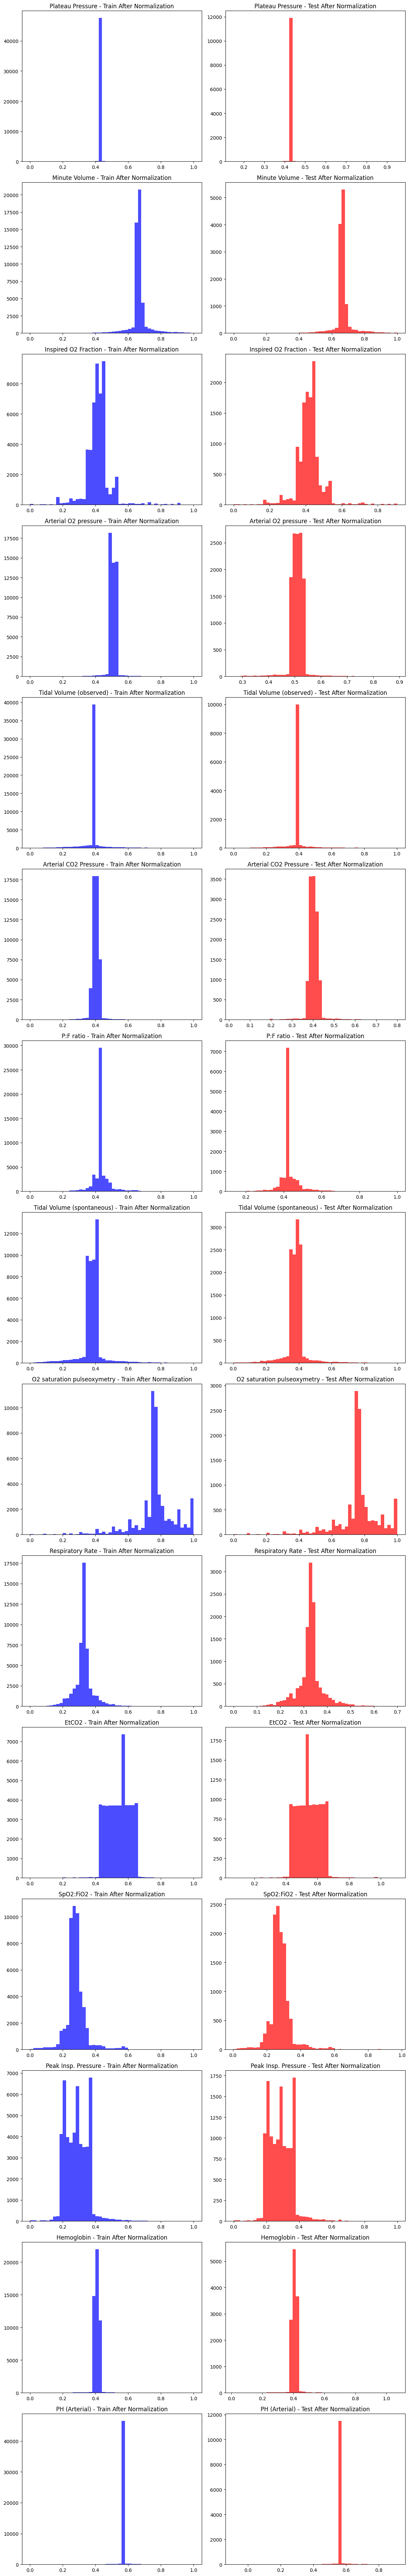

In [ ]:
# Plot histograms for numerical features before normalization
fig, axes = plt.subplots(len(numerical_features), 2, figsize=(12, 5 * len(numerical_features)))

for i, feature in enumerate(numerical_features):
    feature_mask_train = train_df_copy_6['feature_label'] == feature
    feature_mask_test = test_df_copy_6['feature_label'] == feature

    # Plot training data before normalization
    axes[i, 0].hist(train_df_copy_6.loc[feature_mask_train, 'valuenum'], bins=50, color='blue', alpha=0.7)
    axes[i, 0].set_title(f'{feature} - Train After Normalization')

    # Plot test data before normalization
    axes[i, 1].hist(test_df_copy_6.loc[feature_mask_test, 'valuenum'], bins=50, color='red', alpha=0.7)
    axes[i, 1].set_title(f'{feature} - Test After Normalization')

plt.tight_layout()
plt.show()

**Convert Time Series Data into Sequences for LSTM**

In [ ]:
train_copy_8 = train_df_copy_6.copy()
test_copy_8 = test_df_copy_6.copy()

In [ ]:
# Save these to parquet for now as temp data
train_copy_8.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/notebooks/03_data_preprocessing/04_specific_model_preprocessing/01_feature_set_1/01_lstm_preprocessing/csv_for_visualisation/train_copy_8.parquet')
test_copy_8.to_parquet('/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/notebooks/03_data_preprocessing/04_specific_model_preprocessing/01_feature_set_1/01_lstm_preprocessing/csv_for_visualisation/test_copy_8.parquet')

In [ ]:
# Define sequence length (number of time steps)
sequence_length = 13  # 13 time steps for 6.5 hours of data at 30-minute intervals

In [ ]:
# Count the features in the data
feature_list = train_copy_8['feature_label'].unique()

# Display the list
feature_list

# Count the features
feature_count = len(feature_list)

# Display the count
feature_count

16

In [ ]:
train_sequences, train_labels, train_subject_ids = create_sequences(train_df_copy_6, sequence_length)

print("Shape of training sequences:", train_sequences.shape)
print("Shape of training labels:", train_labels.shape)

test_sequences, test_labels, test_subject_ids = create_sequences(test_df_copy_6, sequence_length)

print("Shape of test sequences:", test_sequences.shape)
print("Shape of test labels:", test_labels.shape)

Shape of training sequences: (3760, 13, 16)
Shape of training labels: (3760,)
Shape of test sequences: (941, 13, 16)
Shape of test labels: (941,)


In [ ]:
# Save the train and test data into the drive for input into the model
output_dir = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/'

# Save the training data
np.save(output_dir + 'train_sequences_v02.npy', train_sequences)
np.save(output_dir + 'train_labels_v02.npy', train_labels)

# Save the test data
np.save(output_dir + 'test_sequences_v02.npy', test_sequences)
np.save(output_dir + 'test_labels_v02.npy', test_labels)

# Ventilator mode data needs be normalised

In alignment with Fabregat et al. the Ventilator Mode data will be treated as numerical data and normalised to scale the data.

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load train and test data prior to sequence creation
train = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/notebooks/03_data_preprocessing/04_specific_model_preprocessing/01_feature_set_1/01_lstm_preprocessing/csv_for_visualisation/train_copy_8.parquet'
test = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/notebooks/03_data_preprocessing/04_specific_model_preprocessing/01_feature_set_1/01_lstm_preprocessing/csv_for_visualisation/test_copy_8.parquet'

train_df_copy_9 = pd.read_parquet(train)
test_df_copy_9 = pd.read_parquet(test)

train_df_copy_9.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.438183,EtCO2,1
1,0 days 00:30:00,10001884,0.455869,EtCO2,1
2,0 days 01:00:00,10001884,0.473554,EtCO2,1
3,0 days 01:30:00,10001884,0.491239,EtCO2,1
4,0 days 02:00:00,10001884,0.508924,EtCO2,1


In [ ]:
# Apply MinMaxScaling just to Ventilator Mode feature label
vent_mode_mask = train_df_copy_9['feature_label'] == 'Ventilator Mode'
vent_mode_data = train_df_copy_9.loc[vent_mode_mask, 'valuenum'].values
vent_mode_data

array([11., 11., 11., ..., 11., 30., 30.])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Scale vent mode data
vent_scaler = MinMaxScaler()
scaled_vent_mode_data = vent_scaler.fit_transform(vent_mode_data.reshape(-1, 1))
scaled_vent_mode_data

array([[0.13043478],
       [0.13043478],
       [0.13043478],
       ...,
       [0.13043478],
       [0.4057971 ],
       [0.4057971 ]])

In [ ]:
# Apply to the test data as well with the fitted scaler
test_vent_mode_mask = test_df_copy_9['feature_label'] == 'Ventilator Mode'
test_vent_mode_data = test_df_copy_9.loc[test_vent_mode_mask, 'valuenum'].values

scaled_test_vent_mode_data = vent_scaler.transform(test_vent_mode_data.reshape(-1, 1))
scaled_test_vent_mode_data

array([[0.13043478],
       [0.13043478],
       [0.13043478],
       ...,
       [0.13043478],
       [0.4057971 ],
       [0.4057971 ]])

In [ ]:
# Incorporate this into the train and test sets
train_df_copy_9.loc[vent_mode_mask, 'valuenum'] = scaled_vent_mode_data
test_df_copy_9.loc[test_vent_mode_mask, 'valuenum'] = scaled_test_vent_mode_data

train_df_copy_9.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.438183,EtCO2,1
1,0 days 00:30:00,10001884,0.455869,EtCO2,1
2,0 days 01:00:00,10001884,0.473554,EtCO2,1
3,0 days 01:30:00,10001884,0.491239,EtCO2,1
4,0 days 02:00:00,10001884,0.508924,EtCO2,1


In [ ]:
# Calculate the max value across all valuenums
max_value = train_df_copy_9['valuenum'].max()

# Display the result
print(f"Maximum value: {max_value}")

Maximum value: 1.0


Previously the max value would have been the ventilator mode - the max value being 1 indicates that all data has been successfully scaled.

Now we can convert this data into sequences for LSTM input.

In [ ]:
# Convert the data into sequences for LSTM input
train_sequences_v2, train_labels_v2, train_subject_ids_v2 = create_sequences(train_df_copy_9, sequence_length)

print("Shape of training sequences:", train_sequences_v2.shape)
print("Shape of training labels:", train_labels_v2.shape)

test_sequences_v2, test_labels_v2, test_subject_ids_v2 = create_sequences(test_df_copy_9, sequence_length)

print("Shape of test sequences:", test_sequences_v2.shape)
print("Shape of test labels:", test_labels_v2.shape)

Shape of training sequences: (3760, 13, 16)
Shape of training labels: (3760,)
Shape of test sequences: (941, 13, 16)
Shape of test labels: (941,)


In [ ]:
# Save the sequences to be used for the LSTM model
np.save(output_dir + 'train_sequences_v03.npy', train_sequences_v2)
np.save(output_dir + 'train_labels_v03.npy', train_labels_v2)
np.save(output_dir + 'test_sequences_v03.npy', test_sequences_v2)
np.save(output_dir + 'test_labels_v03.npy', test_labels_v2)

**Saving feature names for use with feature ablation.**

In [ ]:
train_copy_10 = train_df_copy_9.copy()
test_copy_10 = test_df_copy_9.copy()

train_copy_10.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.438183,EtCO2,1
1,0 days 00:30:00,10001884,0.455869,EtCO2,1
2,0 days 01:00:00,10001884,0.473554,EtCO2,1
3,0 days 01:30:00,10001884,0.491239,EtCO2,1
4,0 days 02:00:00,10001884,0.508924,EtCO2,1


In [ ]:
feature_names = train_copy_10['feature_label'].unique().tolist()
feature_names

['EtCO2',
 'Inspired O2 Fraction',
 'Minute Volume',
 'O2 saturation pulseoxymetry',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Arterial CO2 Pressure',
 'Arterial O2 pressure',
 'PH (Arterial)',
 'Ventilator Mode',
 'Hemoglobin',
 'Plateau Pressure',
 'SpO2:FiO2',
 'P:F ratio']

In [ ]:
output_dir = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/'

In [ ]:
# Save feature names for use in feature ablation
np.save(output_dir + 'feature_names_v1.npy', feature_names)

In [ ]:
# Save as a pickle file
import pickle

with open(output_dir + 'feature_names_v1.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# **Redefine sequences so the feature labels are known**

We will re-run the sequence creation to ensure the features are well defined for use later on.

In [ ]:
train_copy_11 = train_df_copy_9.copy()
test_copy_11 = test_df_copy_9.copy()
train_copy_11.head()

,time_from_window_start_mins,subject_id,valuenum,feature_label,extubation_failure
0,0 days 00:00:00,10001884,0.438183,EtCO2,1
1,0 days 00:30:00,10001884,0.455869,EtCO2,1
2,0 days 01:00:00,10001884,0.473554,EtCO2,1
3,0 days 01:30:00,10001884,0.491239,EtCO2,1
4,0 days 02:00:00,10001884,0.508924,EtCO2,1


In [ ]:
max_value = train_df_copy_9['valuenum'].max()
max_value

1.0

In [ ]:
feature_names_2 = train_copy_11['feature_label'].unique().tolist()
feature_names_2

['EtCO2',
 'Inspired O2 Fraction',
 'Minute Volume',
 'O2 saturation pulseoxymetry',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Arterial CO2 Pressure',
 'Arterial O2 pressure',
 'PH (Arterial)',
 'Ventilator Mode',
 'Hemoglobin',
 'Plateau Pressure',
 'SpO2:FiO2',
 'P:F ratio']

In [ ]:
# Save feature names as pkl file
import pickle

with open(output_dir + 'feature_names_v2.pkl', 'wb') as f:
    pickle.dump(feature_names_2, f)

In [ ]:
# Define sequence creation function that maintains feature names
def create_sequences_2(data, sequence_length):
    """
    Convert time series data into sequences for LSTM input, including subject IDs.

    Parameters:
    data (pd.DataFrame): The input DataFrame containing time series data.
    sequence_length (int): The length of each sequence.

    Returns:
    np.array: Numpy array of sequences.
    np.array: Numpy array of labels.
    list: List of subject IDs corresponding to each sequence.
    """
    sequences = []
    labels = []
    subject_ids = []

    # Extract unique feature labels
    feature_labels = data['feature_label'].unique()

    # Group data by patient
    grouped = data.groupby('subject_id')

    for subject_id, group in grouped:
        # Ensure data is sorted by time
        group = group.sort_values(by='time_from_window_start_mins')

        # Pivot the data to ensure all features are included
        pivoted_data = group.pivot(index='time_from_window_start_mins', columns='feature_label', values='valuenum')

        # Ensure the pivoted data has the correct order of columns
        pivoted_data = pivoted_data[feature_labels]

        # Create sequences
        for i in range(len(pivoted_data) - sequence_length + 1):
            sequence = pivoted_data.iloc[i:i + sequence_length]
            sequences.append(sequence.values)
            labels.append(group['extubation_failure'].iloc[i + sequence_length - 1])
            subject_ids.append(subject_id)

    return np.array(sequences), np.array(labels), subject_ids

In [ ]:
sequence_length = 13

In [ ]:
# Create sequences of the train and test data
train_sequences_3, train_labels_3, train_subject_ids_3 = create_sequences_2(train_copy_11, sequence_length)
test_sequences_3, test_labels_3, test_subject_ids_3 = create_sequences_2(test_copy_11, sequence_length)

print("Shape of training sequences:", train_sequences_3.shape)
print("Shape of training labels:", train_labels_3.shape)

print("Shape of test sequences:", test_sequences_3.shape)
print("Shape of test labels:", test_labels_3.shape)

# Save to drive for model input
np.save(output_dir + 'train_sequences_v04.npy', train_sequences_3)
np.save(output_dir + 'train_labels_v04.npy', train_labels_3)


Shape of training sequences: (3760, 13, 16)
Shape of training labels: (3760,)
Shape of test sequences: (941, 13, 16)
Shape of test labels: (941,)


In [ ]:
np.save(output_dir + 'test_sequences_v04.npy', test_sequences_3)
np.save(output_dir + 'test_labels_v04.npy', test_labels_3)